### Módulos Principales

In [ ]:
!pip install transformers gdown datasets evaluate transformers[torch] TensorFlow accelerate -U keras

In [ ]:
from transformers import AutoTokenizer, AutoModel, Trainer, AutoModelForSequenceClassification, TrainingArguments
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
import json
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate

### Dataset (Descarga de Google Drive)

In [ ]:
!pip install gdown
!gdown --folder https://drive.google.com/drive/folders/14DulzxuH5TDhXtviRVXsH5e2JTY2POLi

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/13aFJK4UyY3Gxg_2ceEAWfJvzopB1vkPc

In [ ]:
file_path = "SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl"
with open(file_path) as f:
  # data = [json.loads(l) for l in f]
  data = pd.read_json(path_or_buf=file_path, lines=True)

In [ ]:
data

,text,label,model,source,id
0,Giving gifts should always be enjoyable. Howe...,1,bloomz,wikihow,0
1,Yveltal (Japanese: ユベルタル) is one of the main a...,1,bloomz,wikihow,1
2,If you'd rather not annoy others by being rude...,1,bloomz,wikihow,2
3,If you're interested in visiting gravesite(s) ...,1,bloomz,wikihow,3
4,The following are some tips for becoming succe...,1,bloomz,wikihow,4
...,...,...,...,...,...
4995,The paper deals with an interesting applicatio...,0,human,peerread,4995
4996,This manuscript tries to tackle neural network...,0,human,peerread,4996
4997,The paper introduced a regularization scheme t...,0,human,peerread,4997
4998,Inspired by the analysis on the effect of the ...,0,human,peerread,4998


### LLMs

#### Utils

In [ ]:
# Si el modelo es xlnet-base-cased el cls_pos debe de ser -1
def data_to_vec(model, tokenizer, df_path, save_path, cls_pos=0):
  """ Genera y guarda un dataset con los embeddings generados por el modelo dado

  Parámetros
  ----------
  model: Model (HuggingFace)
    Modelo con el que se generaran los embeddings
  tokenizer: Tokenizer (HuggingFace)
    Tokenizador para generar los vectores de entrada
  df_path: str or Path
    Ruta del dataset en formato JSONL
  save_path: str or Path
    Ruta para guardar el dataset de los embeddings
  cls_pos: int
    Posiciones el token CLS, por defecto es 0 pero algunos modelos lo tienen
    al final (-1)
  """

  with open(df_path) as f:
    data = pd.read_json(path_or_buf=df_path, lines=True)
  output = open(save_path, 'wb')
  d = data['text']
  for text in tqdm(d):
    input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    if torch.cuda.is_available:
      input.to("cuda")
      model.to("cuda")
    o = model(**input).last_hidden_state[0,cls_pos,:].detach().to("cpu").numpy()
    np.savetxt(output, o[None], delimiter=',')
  output.close()

def plot_embeddings(df_path, model_embeddings_path, model_name):
  """ Genera una gráfica 2D con PCA usando los embeddings del modelo dado

  Parámetros
  ----------
  df_path: str or Path
    Ruta al dataset original con la etiqueta 'label'
  model_embeddings_path: str or Path
    Ruta al dataset con embeddings
  model_name: str
    Nombre del modelo para el título la gráfica
  """

  with open(df_path) as f:
    data = pd.read_json(path_or_buf=df_path, lines=True)
  with open(model_embeddings_path) as f:
    embeddings = pd.read_csv(f, header=None)
  # PCA a 2D
  vecs_2d = PCA(n_components=2).fit_transform(embeddings)
  colors = ['r' if l == 0 else 'b' for l in data['label']]
  fig, ax = plt.subplots()
  scatter = ax.scatter(*vecs_2d.T, c=colors)
  ax.set_title(model_name)
  ax.set_title(model_name)
  # ax.legend(*scatter.legend_elements()[0])#, labels=["humano", "maquina"])
  fig.savefig(model_name+'.png', bbox_inches='tight')

#### Carga de Modelos

In [ ]:
models = [
  # "bayartsogt/structbert-large",
  "xlnet-base-cased",
  "YituTech/conv-bert-base",
  "SpanBERT/spanbert-base-cased",
  "nghuyong/ernie-2.0-base-en",
]

model_names = [m.split('/')[-1] for m in models]

In [ ]:
models_l = []
tokenizers = []

for m in models:
  tokenizer = AutoTokenizer.from_pretrained(m)
  model = AutoModel.from_pretrained(m)
  tokenizers.append(tokenizer)
  models_l.append(model)

#### Gráfica para visualización del Dataset (PCA)

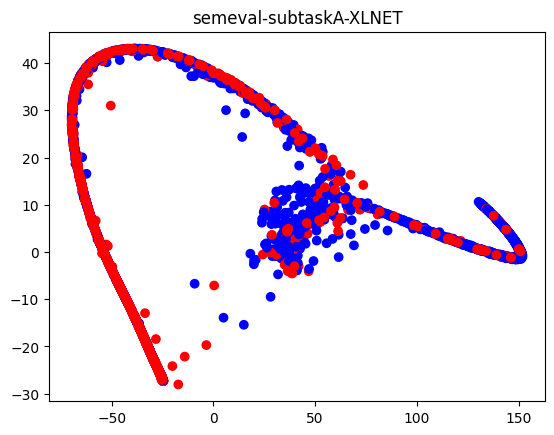

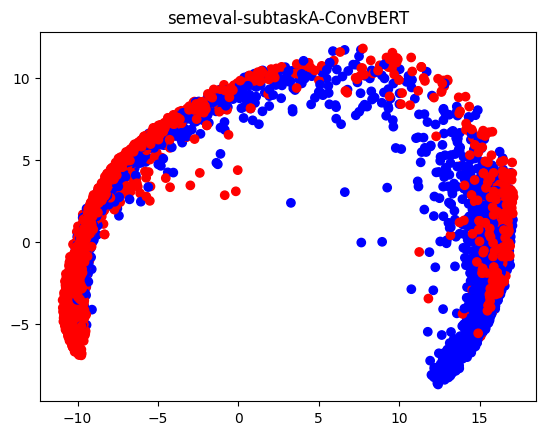

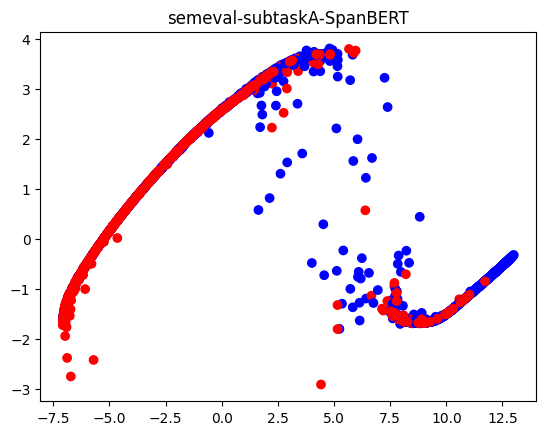

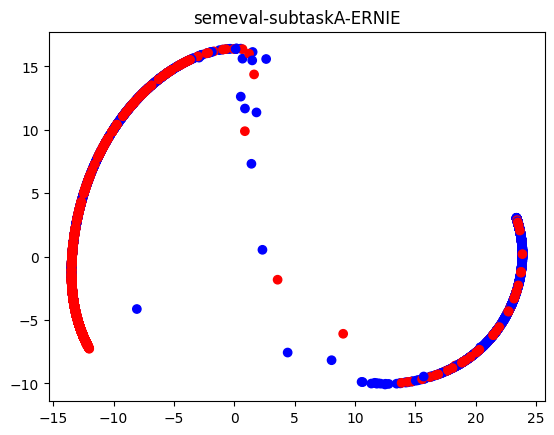

In [ ]:
df_path = "SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl"
save_path = "drive/MyDrive/SemEval/subtaskA_dev_monolingual_" # ernie-2.0-base-en.csv"
# plot_embeddings(df_path, save_path, "nel")

# for i in range(len(models)):
#   plot_embeddings(
#     df_path,
#     save_path+model_names[i]+".csv",
#     model_names[i]
#   )

for i in range(len(trained_models)):
  plot_embeddings(
    df_path,
    save_path+trained_models_names[i]+".csv",
    trained_models_names[i]
  )

#### Procesamiento del dataset a vectores

In [ ]:
df_path = "SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl"
save_path = "drive/MyDrive/SemEval/" # /subtaskA_dev_monolingual_ernie-2.0-base-en.csv"

for i in range(len(models_l)):
  cls_pos = 0 if model_names[i] != "xlnet-base-cased" else -1
  data_to_vec(
    model=models_l[i],
    tokenizer=tokenizers[i],
    df_path=df_path,
    save_path=save_path + "subtaskA_dev_monolingual_" + model_names[i] + ".csv",
    cls_pos=cls_pos
  )

In [ ]:
with open("SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl") as f:
  df_train = pd.read_json(path_or_buf=f, lines=True)

with open("SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl") as f:
  df_test = pd.read_json(path_or_buf=f, lines=True)

p = "drive/MyDrive/SemEval/subtaskA_train_monolingual_ernie-2.0-base-en.csv"
X_train = pd.read_csv(p, header=None)
X_test = pd.read_csv("./subtaskA_dev_monolingual_ernie-2.0-base-en.csv", header=None)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-1.059085,0.348443,-0.007559,0.046112,-0.094601,-0.055321,-0.921863,-0.030267,-0.211962,-0.299773,...,0.340523,-0.477312,1.460746,0.016726,0.815781,-0.750787,1.342456,1.235851,-0.652201,-0.170826
1,-0.939477,0.139399,-0.129068,0.142317,-0.248995,-0.031477,-0.845256,-0.100959,0.068792,-0.172536,...,0.227264,-0.149485,1.449107,-0.176882,0.751371,-0.432411,1.298136,1.619037,-0.539608,-0.117147
2,-0.923671,0.338710,-0.202510,0.050039,-0.335885,-0.089318,-0.845430,-0.146694,-0.005647,-0.276554,...,-0.043827,-0.478081,1.616817,-0.019343,0.792103,-0.384225,1.397380,1.440915,-0.771720,-0.017562
3,-1.029898,0.372864,-0.207118,-0.104755,-0.241882,-0.351709,-0.833356,-0.235825,-0.009782,-0.222632,...,0.622092,-0.541157,1.257885,-0.172356,0.755635,-0.319138,1.174822,1.545286,-0.739481,-0.126820
4,-0.740527,0.294834,-0.116512,0.165027,-0.241172,-0.113504,-0.767482,0.154751,0.169464,-0.047380,...,0.150809,-0.603185,1.527129,-0.072922,0.765196,-0.150367,1.401729,1.154168,-0.645928,-0.058353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,-0.726507,-0.081029,-0.294492,0.256726,-0.549389,0.000974,-0.656983,0.126367,-0.340344,-0.247990,...,0.089792,-0.615607,1.514228,-0.251645,0.633346,0.011279,1.355678,0.824393,-0.635076,-0.080379
16996,-0.959764,0.782773,-0.507224,-0.092332,-0.698509,-0.396671,-1.009485,-0.537023,0.267195,-0.177028,...,-0.024293,-0.404279,1.191594,-0.603512,0.833193,0.179369,0.889249,1.345684,-0.383620,0.653940
16997,-0.740595,0.501844,-0.308914,-0.072860,-0.603105,-0.226243,-0.850350,-0.290536,-0.005854,-0.062282,...,-0.168680,-0.298462,1.061579,-0.613837,0.921226,-0.156506,0.960967,1.342322,-0.162936,0.553686
16998,-0.313920,-0.063325,-0.113108,0.071104,-0.561858,0.074146,-0.308086,0.191022,-0.524784,-0.372150,...,-0.052338,-0.722702,1.281904,-0.252493,0.603993,-0.206892,1.401076,0.882076,-1.118783,-0.133883


#### Fine Tuning

##### Scripts del SemEval

In [ ]:
import requests
res = requests.get("https://raw.githubusercontent.com/mbzuai-nlp/SemEval2024-task8/main/subtaskA/baseline/transformer_baseline.py")
with open("transformer_baseline.py", "wb") as f: f.write(res.content)


In [ ]:
!sed -i -e "s/truncation=True/truncation=True, padding='max_length', max_length=512/" /content/transformer_baseline.py

In [ ]:
import requests
res = requests.get("https://raw.githubusercontent.com/mbzuai-nlp/SemEval2024-task8/main/subtaskA/scorer/scorer.py")
with open("scorer.py", "wb") as f: f.write(res.content)
res = requests.get("https://raw.githubusercontent.com/mbzuai-nlp/SemEval2024-task8/main/subtaskA/format_checker/format_checker.py")
with open("format_checker.py", "wb") as f: f.write(res.content)

In [ ]:
!python3 transformer_baseline.py --train_file_path SemEval2024-Task8/SubtaskB/subtaskB_train.jsonl --test_file_path SemEval2024-Task8/SubtaskB/ --prediction_file_path subtaskB_predictions_xlnet.jsonl --subtask B --model xlnet-base-case

In [ ]:
!python3 scorer.py --gold_file_path=SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl --pred_file_path=subtaskA_baseline_predictions.jsonl

INFO : Prediction file format is correct
INFO : macro-F1=0.70961	micro-F1=0.72960	accuracy=0.72960


##### Desde Colab

In [ ]:
train_path = "SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl"
train_df = pd.read_json(path_or_buf=train_path, lines=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
# Este código es el mismo que está en el transformer baseline

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def fine_tune(model, tokenizer):
  tokenize = lambda data: tokenizer(
    data['text'],
    return_tensors='pt',
    padding='max_length',
    truncation=True,
    max_length=512
  )

  tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
  tokenized_val_dataset = val_dataset.map(tokenize, batched=True)

  training_args = TrainingArguments(
    num_train_epochs=3,
    output_dir='test',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True
  )

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
  )

  trainer.train()

In [ ]:
fine_tune(models_l[0], tokenizers[0])

#### Modelos Entrenados

In [ ]:
trained_models = [
  "andricValdez/semeval-subtaskA-XLNET",
  "andricValdez/semeval-subtaskA-ConvBERT",
  "andricValdez/semeval-subtaskA-SpanBERT",
  "andricValdez/semeval-subtaskA-ERNIE",
#  "andricValdez/semeval-subtaskB-XLNET",
#  "andricValdez/semeval-subtaskB-ConvBERT",
#  "andricValdez/semeval-subtaskB-SpanBERT",
#  "andricValdez/semeval-subtaskB-ERNIE",
]

trained_models_names = [m.split('/')[-1] for m in trained_models]

In [ ]:
from huggingface_hub import snapshot_download

In [ ]:
snapshot_download(repo_id=trained_models[0], allow_patterns="best/*")

In [ ]:
model = AutoModel.from_pretrained("/root/.cache/huggingface/hub/models--andricValdez--semeval-subtaskA-XLNET/snapshots/dbbd537cb00f547acc448786c547d444006c3c57/best")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/root/.cache/huggingface/hub/models--andricValdez--semeval-subtaskA-XLNET/snapshots/dbbd537cb00f547acc448786c547d444006c3c57/best")

In [ ]:
df_path = "SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl"
save_path = "drive/MyDrive/SemEval/" # /subtaskA_dev_monolingual_ernie-2.0-base-en.csv"

for i in range(len(trained_models)):
  cls_pos = 0 if trained_models_names[i] != "semeval-subtaskA-XLNET" else -1
  snapshot_path = snapshot_download(repo_id=trained_models[i], allow_patterns="best/*")
  data_to_vec(
    model=AutoModel.from_pretrained(snapshot_path + "/best"),
    tokenizer=AutoTokenizer.from_pretrained(snapshot_path + "/best"),
    df_path=df_path,
    save_path=save_path + "subtaskA_dev_monolingual_" + trained_models_names[i] + ".csv",
    cls_pos=cls_pos
  )

### Estilometria con la biblioteca Stylometry

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

#### Paquetes y preparación de la biblioteca stylometry

In [ ]:
# Hay que cambiar los prints en extract.py y download.py para evitar errores
!git clone https://github.com/jpotts18/stylometry

In [ ]:
# Los los paquetes del requirements.txt con algunos cambios de versiones para funcionar con colab
!pip install mock==1.0.1 nltk nose==1.3.4 numpy pydot python-dateutil==2.4.1 scikit-learn scipy six==1.9.0 stylometry==0.1.0

In [ ]:
!pip uninstall stylometry
!apt-get --reinstall install python3-tz

#### Generación de CSV con las características de stylometry

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
from stylometry.stylometry.extract import *

In [ ]:
from pathlib import Path

def json_to_txt(df_path, dir_path):
  """ Genera un directorio para la biblioteca stylometry a partir de un dataset

  Parámetros
  ----------
  df_path: str or Path
    Ruta del dataset en formato JSONL, debe contar con las colmnas 'model', el
    modelo que generó el texto, y 'text'.
  dir_path: str or Path
    Ruta del directorio donde se guardarán los archivos generados.
  """

  with open(df_path) as f:
    data = pd.read_json(path_or_buf=f, lines=True)

  p = Path(dir_path)
  p.mkdir(exist_ok=True, parents=True)

  for _, d in data.iterrows():
    model_dir = p / d['model']
    if not model_dir.is_dir():
      model_dir.mkdir()
    with open(model_dir / (str(d['id']) + '.txt'), 'w') as f:
      f.write(d['text'])

In [ ]:
json_to_txt("SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl", "data/SubtaskA/dev")
json_to_txt("SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl", "data/SubtaskA/train")
json_to_txt("/content/SemEval2024-Task8-test-gold-labels/additional_information/subtaskA_monolingual.jsonl", "data/SubtaskA/test")

In [ ]:
# Las rutas de drive deben de cambiarse para poder ejecutar las columnas
drive_path = "/content/drive/MyDrive/SemEval/"

In [ ]:
train_corpus = StyloCorpus.from_glob_pattern('data/SubtaskA/train/*/*.txt')
train_corpus.output_csv(drive_path + 'stylometry_train.csv')
dev_corpus = StyloCorpus.from_glob_pattern('data/SubtaskA/dev/*/*.txt')
dev_corpus.output_csv(drive_path + 'stylometry_dev.csv')
test_corpus = StyloCorpus.from_glob_pattern('data/SubtaskA/test/*/*.txt')
test_corpus.output_csv(drive_path + 'stylometry_test.csv')

#### Manipulacion y analisis de los datos

In [ ]:
# Las rutas de drive deben de cambiarse para poder ejecutar las columnas
drive_path = "/content/drive/MyDrive/SemEval/"

In [ ]:
df_stylometry_dev = pd.read_csv(drive_path + "stylometry_dev.csv")
df_stylometry_dev

,Author,Title,LexicalDiversity,MeanWordLen,MeanSentenceLen,StdevSentenceLen,MeanParagraphLen,DocumentLen,Commas,Semicolons,...,Ands,Buts,Howevers,Ifs,Thats,Mores,Musts,Mights,This,Verys
0,human,data/SubtaskA/dev/human/836.txt,46.8085,4.82576,14.8235,6.00231,22.9091,1314,78.0142,7.09220,...,10.63830,3.54610,0.0,7.09220,3.54610,3.54610,0.0,0.00000,3.54610,3.54610
1,human,data/SubtaskA/dev/human/655.txt,43.1507,5.28968,22.3478,11.12230,51.3000,2838,85.6164,1.71233,...,34.24660,6.84932,0.0,1.71233,3.42466,5.13699,0.0,0.00000,1.71233,3.42466
2,human,data/SubtaskA/dev/human/4647.txt,55.1402,5.56780,17.5455,8.93780,96.5000,1189,37.3832,0.00000,...,18.69160,0.00000,0.0,0.00000,4.67290,0.00000,0.0,0.00000,0.00000,0.00000
3,human,data/SubtaskA/dev/human/2685.txt,55.9172,5.01058,17.8750,8.86619,95.3333,1604,73.9645,0.00000,...,17.75150,0.00000,0.0,0.00000,14.79290,2.95858,0.0,0.00000,2.95858,2.95858
4,human,data/SubtaskA/dev/human/2759.txt,46.1119,6.07692,31.2000,21.95590,44.5714,3914,50.4775,0.00000,...,25.92090,1.36426,0.0,1.36426,13.64260,2.72851,0.0,0.00000,1.36426,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,bloomz,data/SubtaskA/dev/bloomz/3042.txt,61.8529,5.33921,27.5000,7.92149,110.0000,1949,46.3215,0.00000,...,8.17439,0.00000,0.0,2.72480,8.17439,5.44959,0.0,2.72480,5.44959,0.00000
4996,bloomz,data/SubtaskA/dev/bloomz/3227.txt,68.4615,5.92509,23.2000,10.93740,348.0000,2215,23.0769,0.00000,...,5.12821,2.56410,0.0,2.56410,7.69231,2.56410,0.0,0.00000,7.69231,0.00000
4997,bloomz,data/SubtaskA/dev/bloomz/4056.txt,85.6322,5.68456,20.2500,6.79614,54.0000,1071,11.4943,0.00000,...,5.74713,5.74713,0.0,5.74713,5.74713,5.74713,0.0,5.74713,11.49430,5.74713
4998,bloomz,data/SubtaskA/dev/bloomz/4268.txt,91.3669,5.72441,26.0000,5.25357,65.0000,879,14.3885,0.00000,...,7.19424,7.19424,0.0,0.00000,7.19424,7.19424,0.0,0.00000,7.19424,7.19424


In [ ]:
df_stylometry_dev["Author"].value_counts()

<ipython-input-10-4df15b6ed95d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stylometry_dev.groupby("Author").mean().plot(kind="bar", subplots=True, figsize=(35,20), layout=(4,6), legend=False)


array([[<Axes: title={'center': 'LexicalDiversity'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanWordLen'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanSentenceLen'}, xlabel='Author'>,
        <Axes: title={'center': 'StdevSentenceLen'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanParagraphLen'}, xlabel='Author'>,
        <Axes: title={'center': 'DocumentLen'}, xlabel='Author'>],
       [<Axes: title={'center': 'Commas'}, xlabel='Author'>,
        <Axes: title={'center': 'Semicolons'}, xlabel='Author'>,
        <Axes: title={'center': 'Quotes'}, xlabel='Author'>,
        <Axes: title={'center': 'Exclamations'}, xlabel='Author'>,
        <Axes: title={'center': 'Colons'}, xlabel='Author'>,
        <Axes: title={'center': 'Dashes'}, xlabel='Author'>],
       [<Axes: title={'center': 'Mdashes'}, xlabel='Author'>,
        <Axes: title={'center': 'Ands'}, xlabel='Author'>,
        <Axes: title={'center': 'Buts'}, xlabel='Author'>,
        <Axes: title={'cent

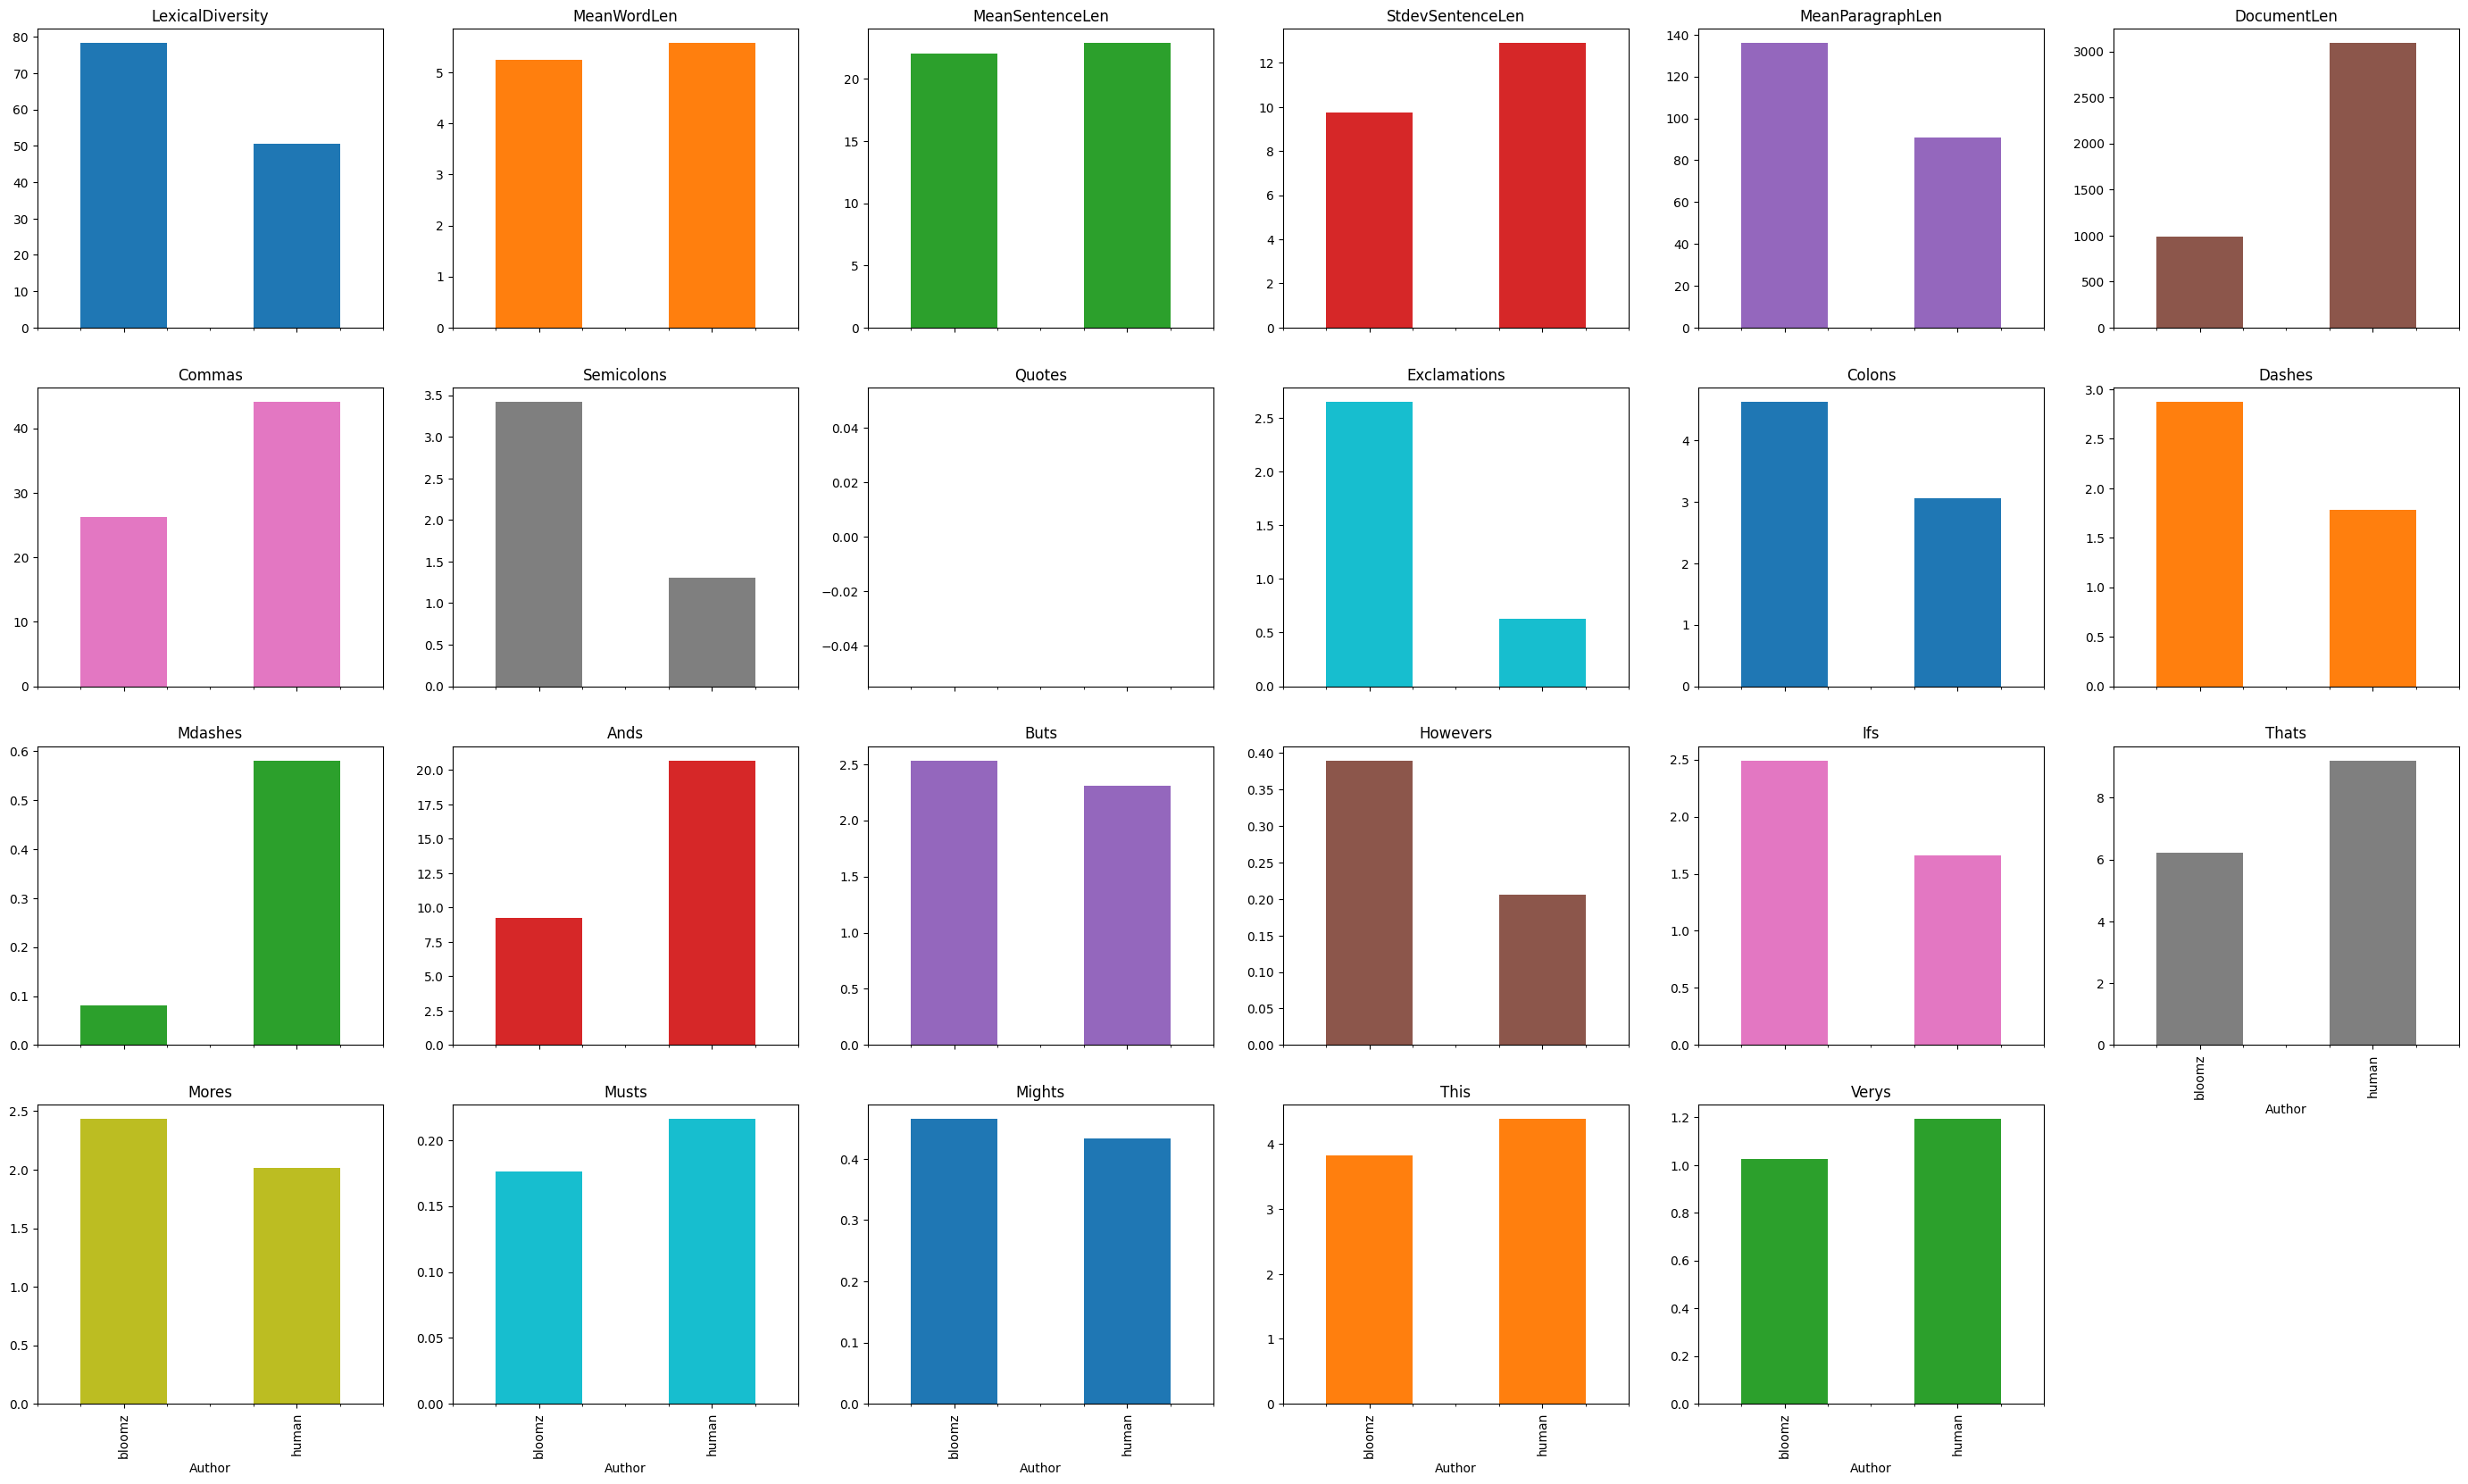

In [ ]:
df_stylometry_dev.groupby("Author").mean().plot(kind="bar", subplots=True, figsize=(35,20), layout=(4,6), legend=False)

In [ ]:
df_stylometry = pd.read_csv(drive_path + "stylometry_train.csv")

In [ ]:
df_stylometry

,Author,Title,LexicalDiversity,MeanWordLen,MeanSentenceLen,StdevSentenceLen,MeanParagraphLen,DocumentLen,Commas,Semicolons,...,Ands,Buts,Howevers,Ifs,Thats,Mores,Musts,Mights,This,Verys
0,chatGPT,data/SubtaskA/train/chatGPT/10771.txt,53.9936,6.07692,21.2308,4.54302,276.0000,1741,57.50800,0.000000,...,57.5080,0.000000,3.194890,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000
1,chatGPT,data/SubtaskA/train/chatGPT/33070.txt,50.8772,6.68103,26.5000,4.21307,70.6667,1408,26.31580,0.000000,...,35.0877,0.000000,0.000000,0.00000,13.15790,0.00000,0.00000,0.000000,4.38596,0.00000
2,chatGPT,data/SubtaskA/train/chatGPT/38474.txt,56.5056,5.93421,19.0833,4.97424,57.2500,1492,85.50190,0.000000,...,22.3048,0.000000,0.000000,0.00000,18.58740,3.71747,0.00000,0.000000,0.00000,0.00000
3,chatGPT,data/SubtaskA/train/chatGPT/27322.txt,32.8767,5.22917,17.6857,7.44416,28.1364,3578,75.34250,0.000000,...,28.7671,0.000000,0.000000,0.00000,2.73973,5.47945,0.00000,0.000000,4.10959,0.00000
4,chatGPT,data/SubtaskA/train/chatGPT/24005.txt,59.4340,6.06349,19.4000,3.20000,64.6667,1256,28.30190,0.000000,...,18.8679,0.000000,0.000000,0.00000,18.86790,4.71698,0.00000,0.000000,4.71698,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119752,human,data/SubtaskA/train/human/74355.txt,50.5929,5.53906,18.5833,14.67120,37.1667,1392,23.71540,7.905140,...,11.8577,0.000000,0.000000,0.00000,3.95257,0.00000,0.00000,0.000000,0.00000,0.00000
119753,human,data/SubtaskA/train/human/71820.txt,22.9897,6.43779,17.8757,10.66190,68.8542,19184,51.53800,0.269833,...,16.4598,0.269833,0.269833,2.42849,7.55532,2.69833,2.69833,0.269833,3.77766,0.00000
119754,human,data/SubtaskA/train/human/110971.txt,45.6274,5.65833,22.4545,9.79205,247.0000,1453,3.80228,0.000000,...,0.0000,0.000000,0.000000,0.00000,30.41830,0.00000,3.80228,0.000000,7.60456,3.80228
119755,human,data/SubtaskA/train/human/91616.txt,56.3158,5.35514,27.6667,15.67020,83.0000,1041,36.84210,0.000000,...,26.3158,5.263160,0.000000,0.00000,21.05260,0.00000,0.00000,0.000000,10.52630,0.00000


In [ ]:
# df = df_stylometry.groupby(df_stylometry["Author"] == "human")
df_multi = df_stylometry.groupby("Author").mean(numeric_only=True)
df_bin = df_stylometry.groupby(df_stylometry["Author"] == "human").mean(numeric_only=True)
df_bin.rename(index={True:"Human", False:"Machine"}, inplace=True)

In [ ]:
df_bin

,LexicalDiversity,MeanWordLen,MeanSentenceLen,StdevSentenceLen,MeanParagraphLen,DocumentLen,Commas,Semicolons,Quotes,Exclamations,...,Ands,Buts,Howevers,Ifs,Thats,Mores,Musts,Mights,This,Verys
Author,,,,,,,,,,,,,,,,,,,,,
Machine,45.617828,5.752934,22.438685,8.338023,180.209451,1910.899674,41.731845,0.309261,0.0,0.417430,...,28.523485,1.181797,0.111645,1.016859,9.459219,1.984377,0.191436,0.298083,3.386385,0.494675
Human,48.287950,5.624618,23.343545,12.374826,99.805423,3510.413900,45.532432,1.310579,0.0,0.571101,...,21.679691,2.131018,0.189985,1.901252,8.763872,2.000918,0.229366,0.531882,3.256172,0.829408


In [ ]:
df_multi

,LexicalDiversity,MeanWordLen,MeanSentenceLen,StdevSentenceLen,MeanParagraphLen,DocumentLen,Commas,Semicolons,Quotes,Exclamations,...,Ands,Buts,Howevers,Ifs,Thats,Mores,Musts,Mights,This,Verys
Author,,,,,,,,,,,,,,,,,,,,,
chatGPT,46.384444,5.957220,20.139887,6.612981,106.520904,2138.415231,42.526040,0.093700,0.0,0.526513,...,32.377822,1.044931,0.049034,0.902910,9.838035,2.143920,0.130050,0.393731,3.885842,0.193981
cohere,43.384500,5.533464,21.099650,7.625451,134.961696,1499.835868,39.472142,0.137551,0.0,0.104047,...,26.110038,1.238339,0.063179,0.888314,11.663925,1.917978,0.169475,0.212402,2.440675,0.603212
davinci,49.204361,5.854962,21.565664,7.344971,136.054939,1897.742174,42.646764,0.363444,0.0,0.436271,...,31.062572,0.910629,0.162684,0.999679,8.193939,2.035227,0.277622,0.254918,3.013328,0.323914
dolly,43.347666,5.653920,26.980870,11.807003,344.585576,2092.367934,42.187321,0.641200,0.0,0.592003,...,24.346184,1.543360,0.170642,1.275907,8.217590,1.834240,0.187482,0.327955,4.178389,0.870318
human,48.287950,5.624618,23.343545,12.374826,99.805423,3510.413900,45.532432,1.310579,0.0,0.571101,...,21.679691,2.131018,0.189985,1.901252,8.763872,2.000918,0.229366,0.531882,3.256172,0.829408


In [ ]:
phraseology = ['LexicalDiversity', 'MeanWordLen', 'MeanSentenceLen', 'StdevSentenceLen', 'MeanParagraphLen'] # DocumentLen
punctuation = ['Semicolons', 'Exclamations', 'Colons', 'Dashes', 'Mdashes'] # Commas
lexical_usage_1 = ['Buts', 'Howevers', 'Ifs', 'Mores', 'Musts', 'Mights', 'This', 'Verys']
lexical_usage_2 = ['Ands', 'Thats']

array([[<Axes: title={'center': 'LexicalDiversity'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanWordLen'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanSentenceLen'}, xlabel='Author'>,
        <Axes: title={'center': 'StdevSentenceLen'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanParagraphLen'}, xlabel='Author'>,
        <Axes: title={'center': 'DocumentLen'}, xlabel='Author'>],
       [<Axes: title={'center': 'Commas'}, xlabel='Author'>,
        <Axes: title={'center': 'Semicolons'}, xlabel='Author'>,
        <Axes: title={'center': 'Quotes'}, xlabel='Author'>,
        <Axes: title={'center': 'Exclamations'}, xlabel='Author'>,
        <Axes: title={'center': 'Colons'}, xlabel='Author'>,
        <Axes: title={'center': 'Dashes'}, xlabel='Author'>],
       [<Axes: title={'center': 'Mdashes'}, xlabel='Author'>,
        <Axes: title={'center': 'Ands'}, xlabel='Author'>,
        <Axes: title={'center': 'Buts'}, xlabel='Author'>,
        <Axes: title={'cent

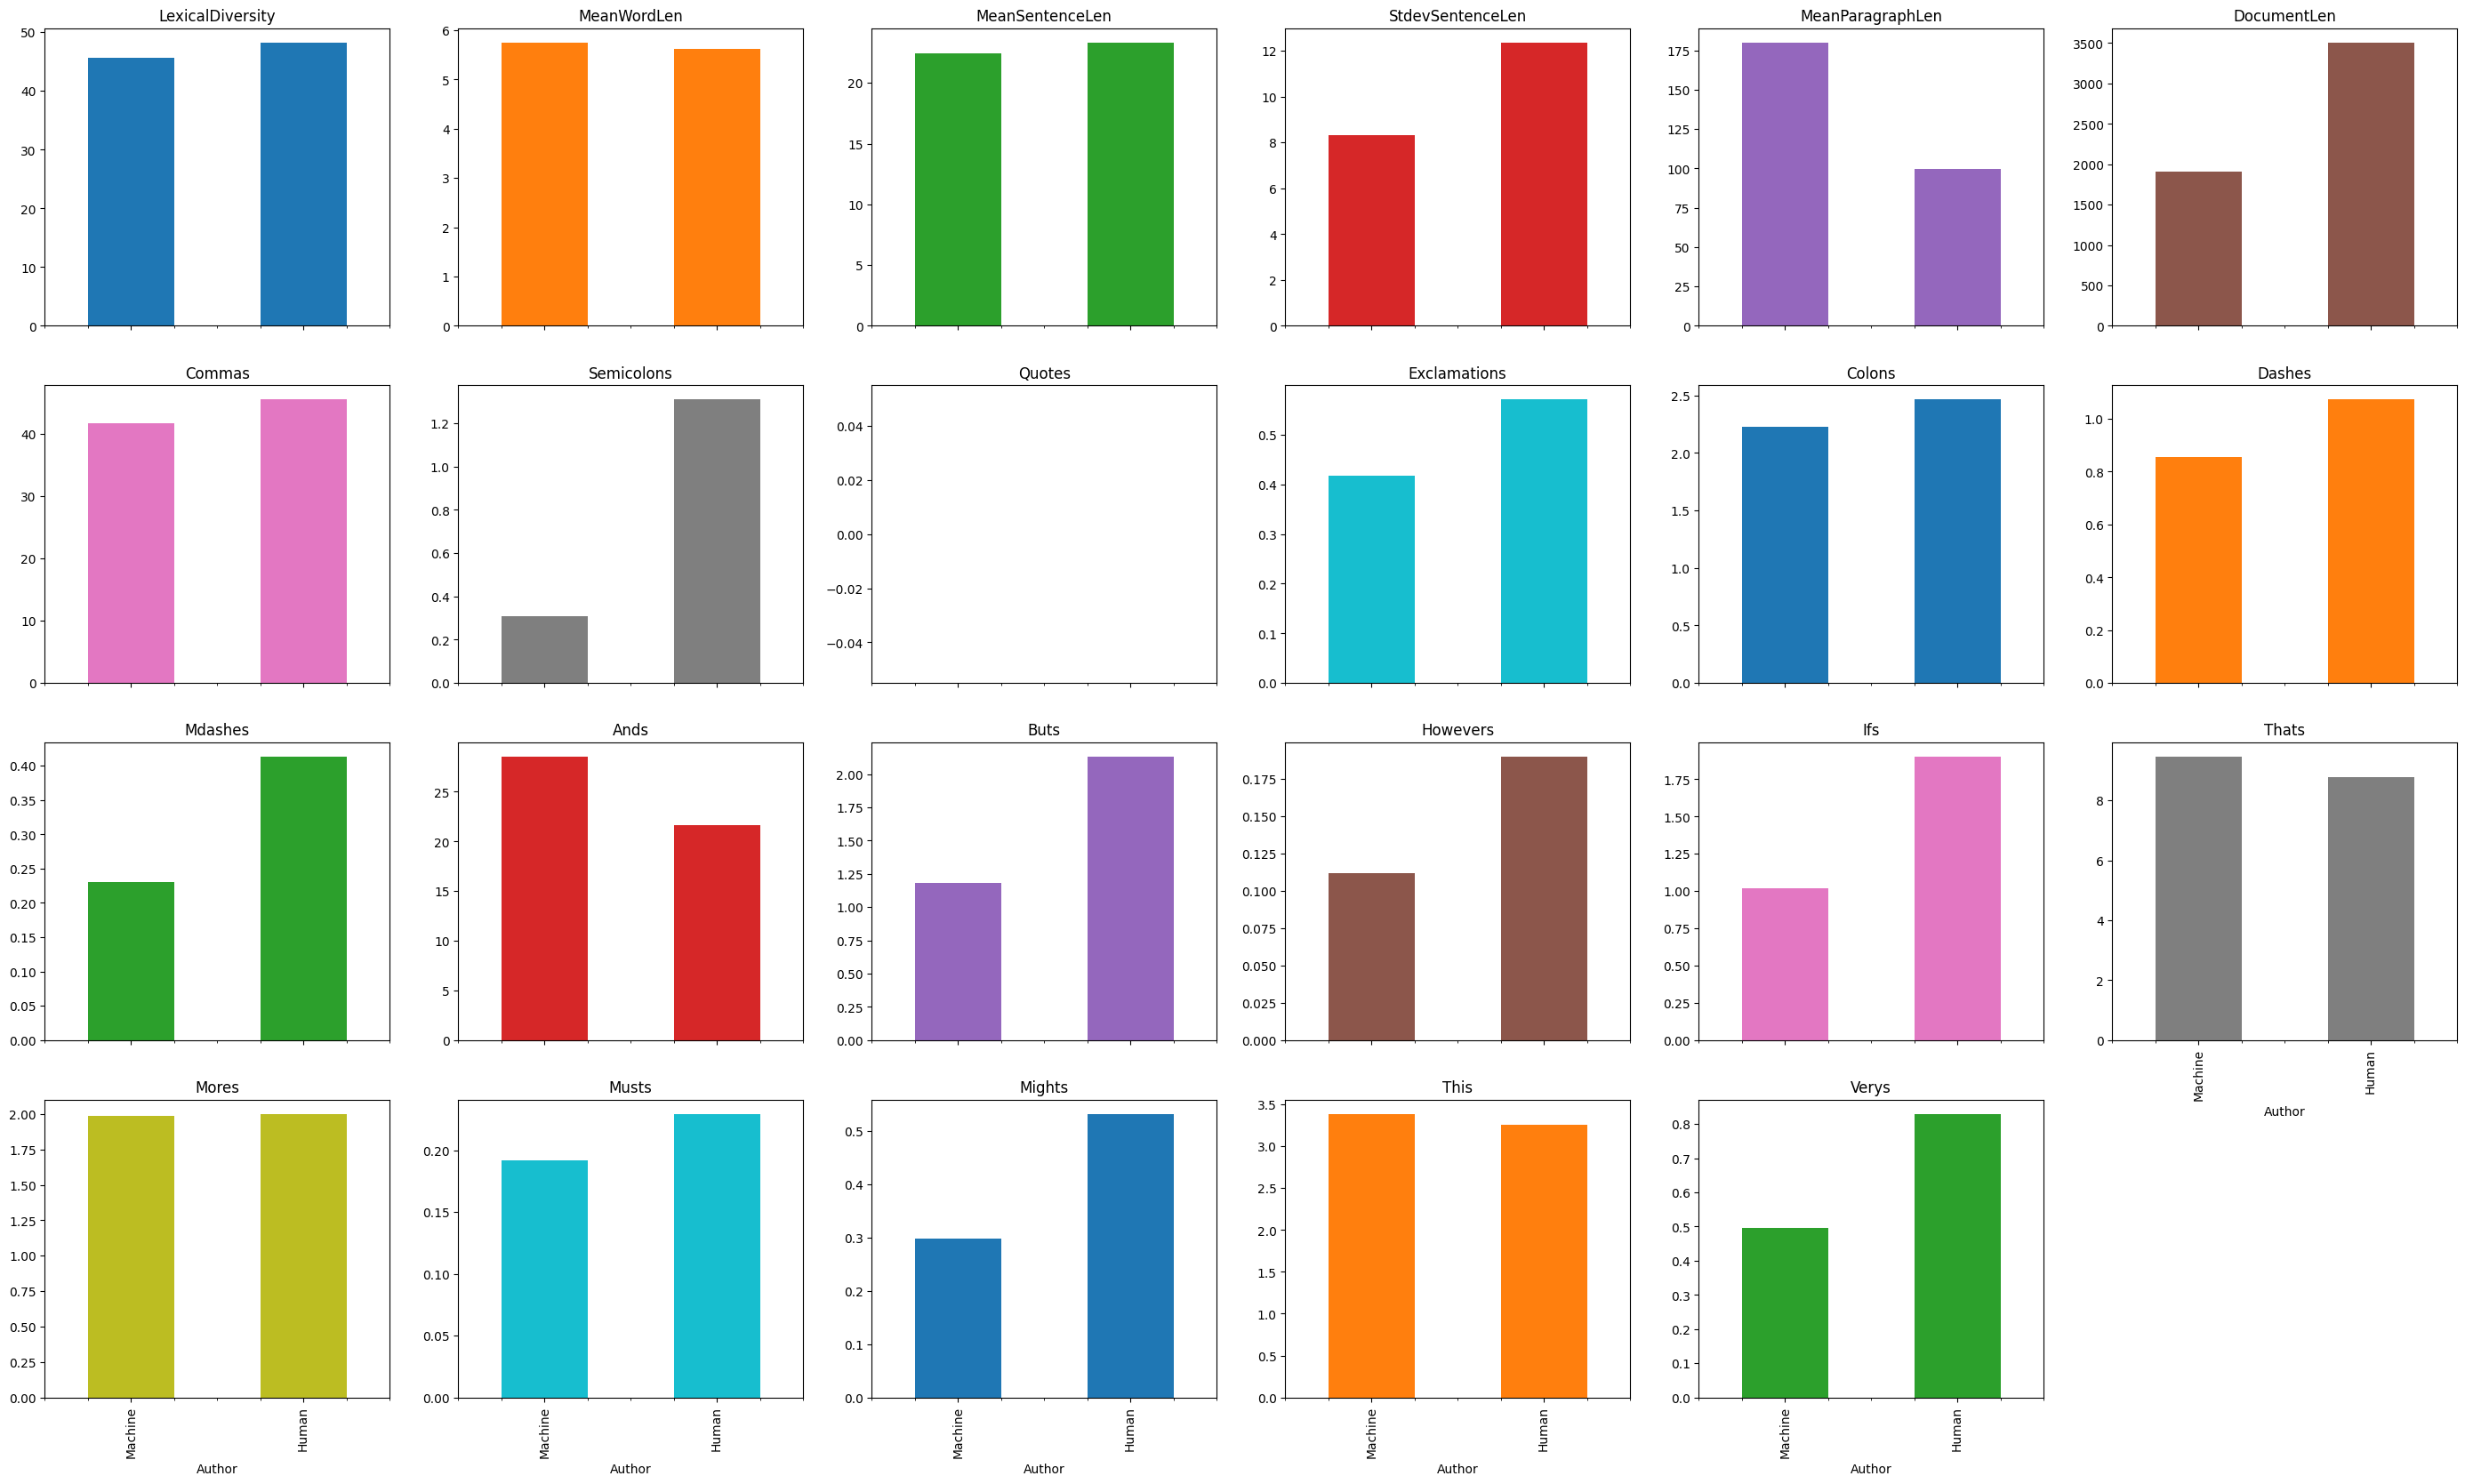

In [ ]:
df_bin.plot(kind="bar", subplots=True, figsize=(35,20), layout=(4,6), legend=False)

array([[<Axes: title={'center': 'LexicalDiversity'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanWordLen'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanSentenceLen'}, xlabel='Author'>,
        <Axes: title={'center': 'StdevSentenceLen'}, xlabel='Author'>,
        <Axes: title={'center': 'MeanParagraphLen'}, xlabel='Author'>,
        <Axes: title={'center': 'DocumentLen'}, xlabel='Author'>],
       [<Axes: title={'center': 'Commas'}, xlabel='Author'>,
        <Axes: title={'center': 'Semicolons'}, xlabel='Author'>,
        <Axes: title={'center': 'Quotes'}, xlabel='Author'>,
        <Axes: title={'center': 'Exclamations'}, xlabel='Author'>,
        <Axes: title={'center': 'Colons'}, xlabel='Author'>,
        <Axes: title={'center': 'Dashes'}, xlabel='Author'>],
       [<Axes: title={'center': 'Mdashes'}, xlabel='Author'>,
        <Axes: title={'center': 'Ands'}, xlabel='Author'>,
        <Axes: title={'center': 'Buts'}, xlabel='Author'>,
        <Axes: title={'cent

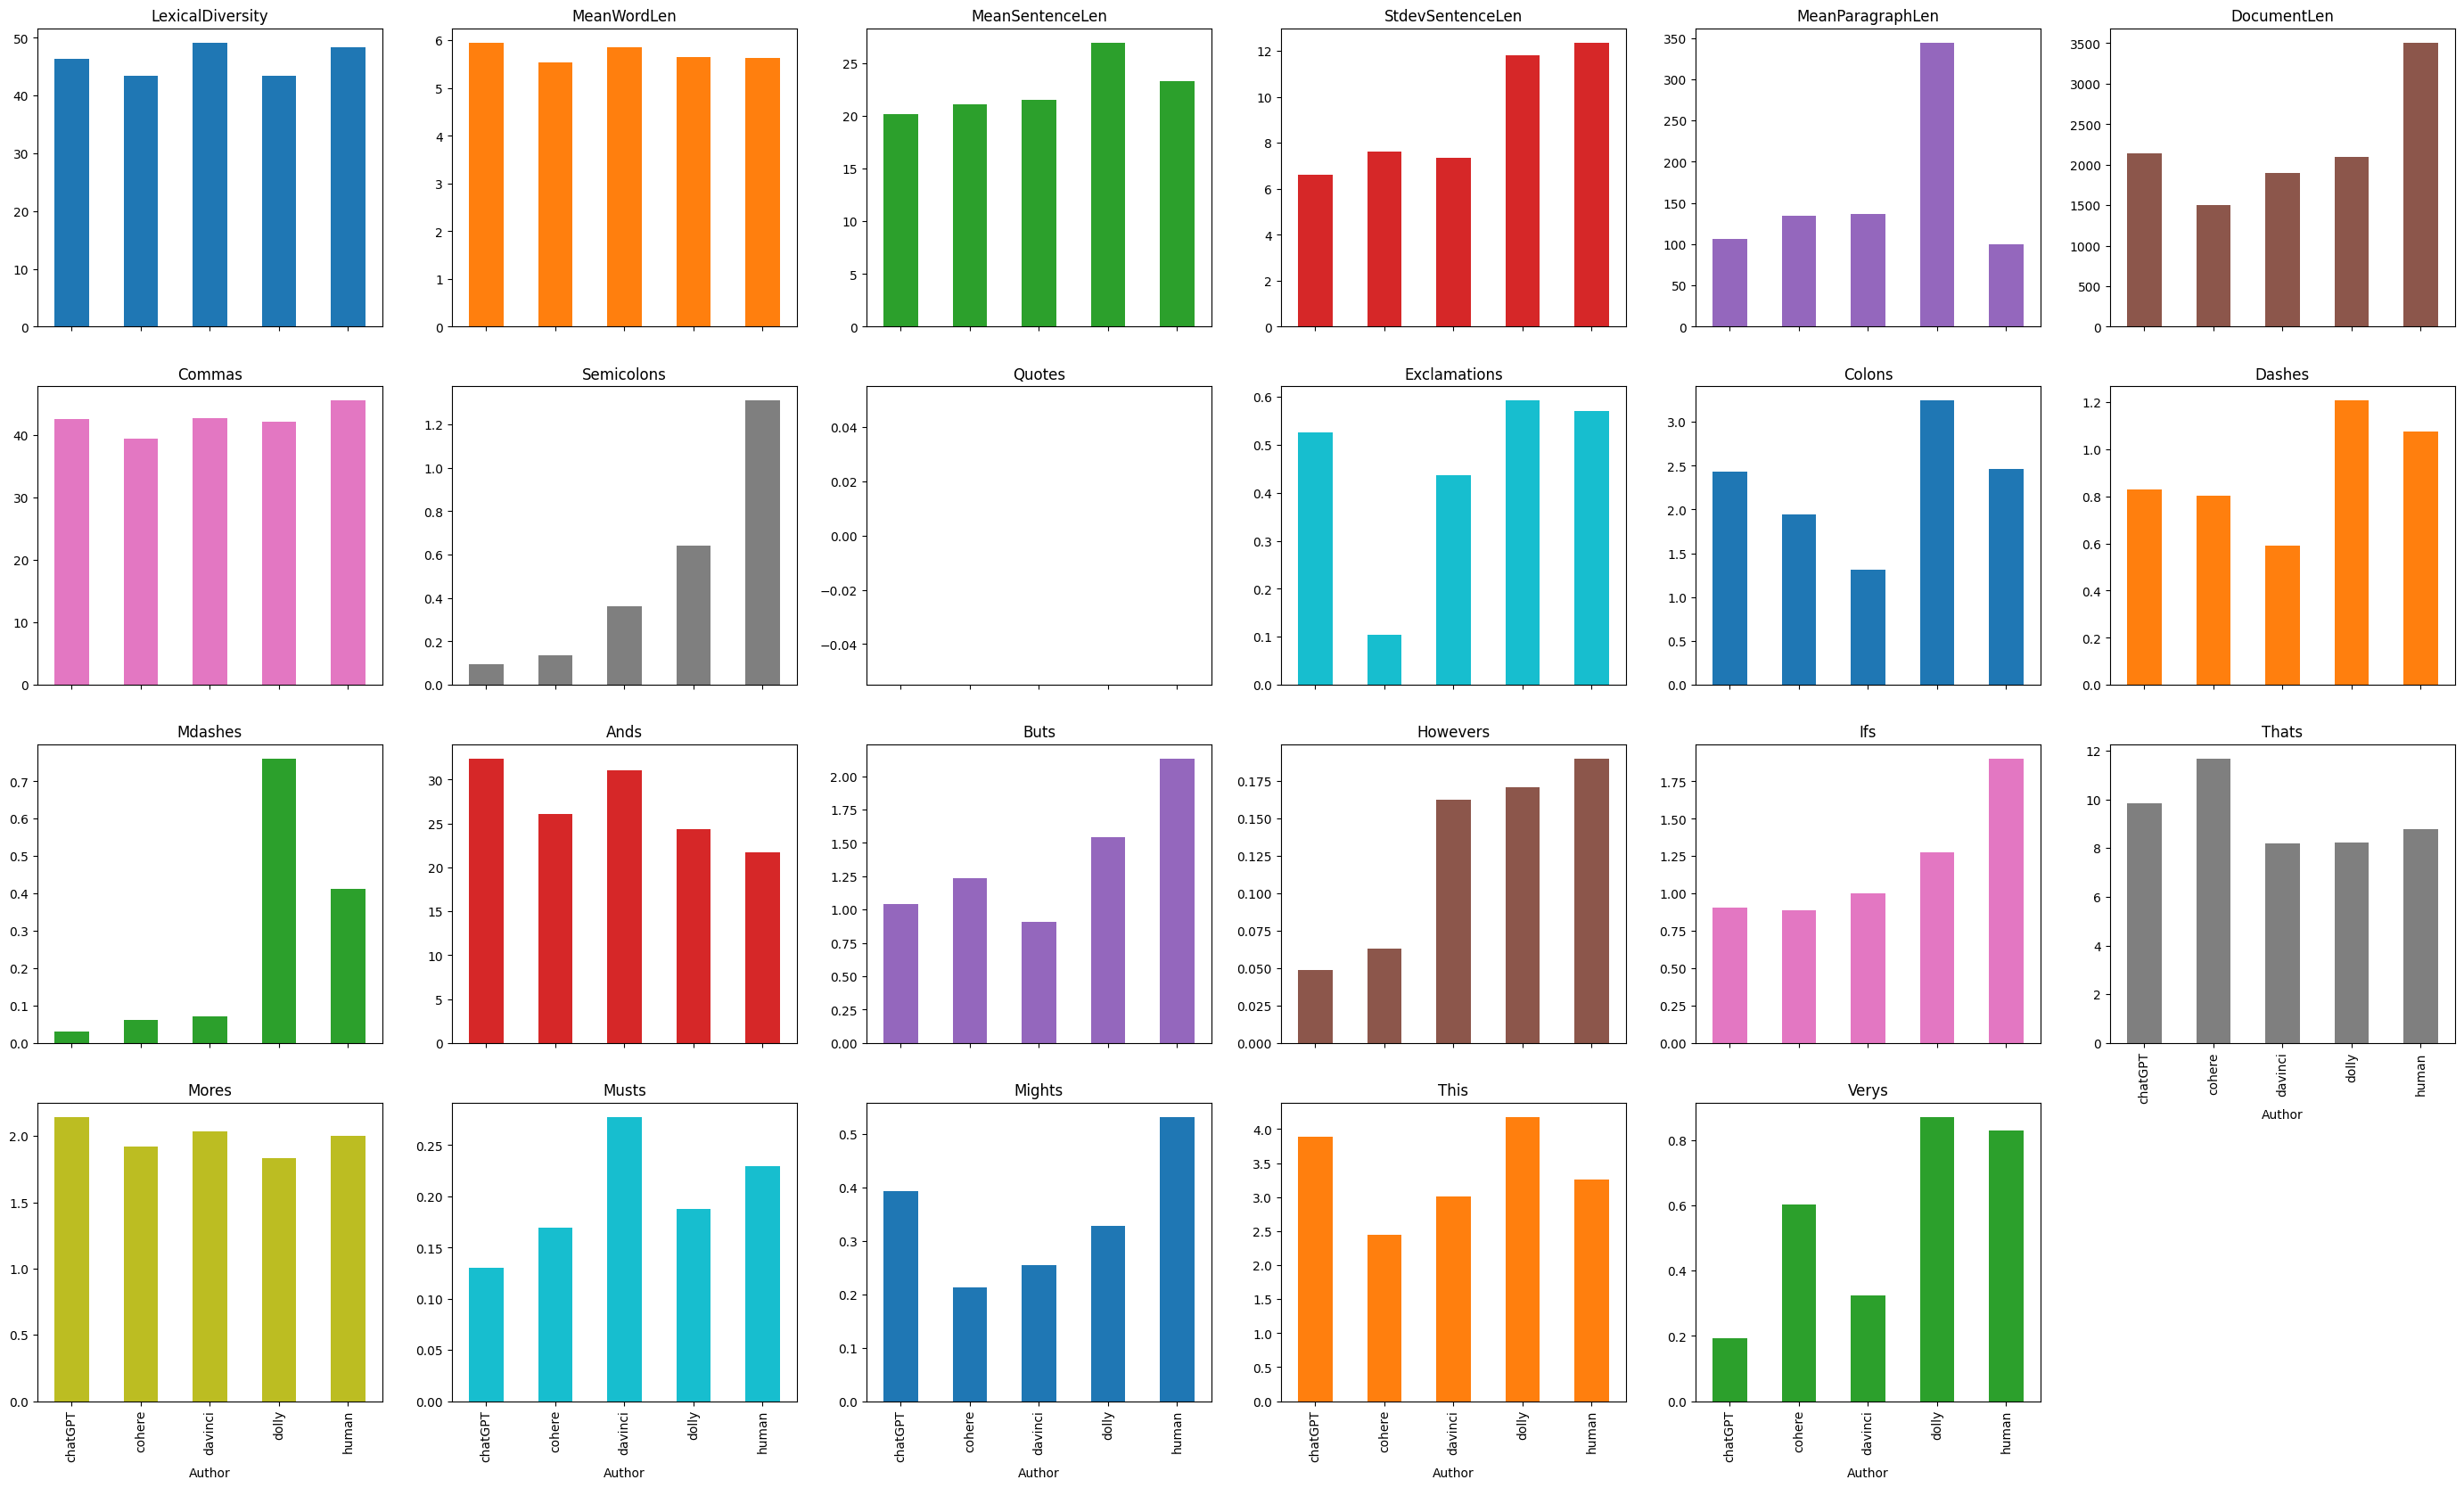

In [ ]:
df_multi.plot(kind="bar", subplots=True, figsize=(35,20), layout=(4,6), legend=False)

In [ ]:
def plot_group(group):
  """ Genera gráficas apartir de grupo de columnas dado en el dataset df_stylometry

  Parámetros
  ----------
  group: list
    Lista con las columnas a agrupar
  """
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  df_multi[group].plot(kind="bar", ax=axs[0])
  df_bin[group].plot(kind="bar", ax=axs[1])

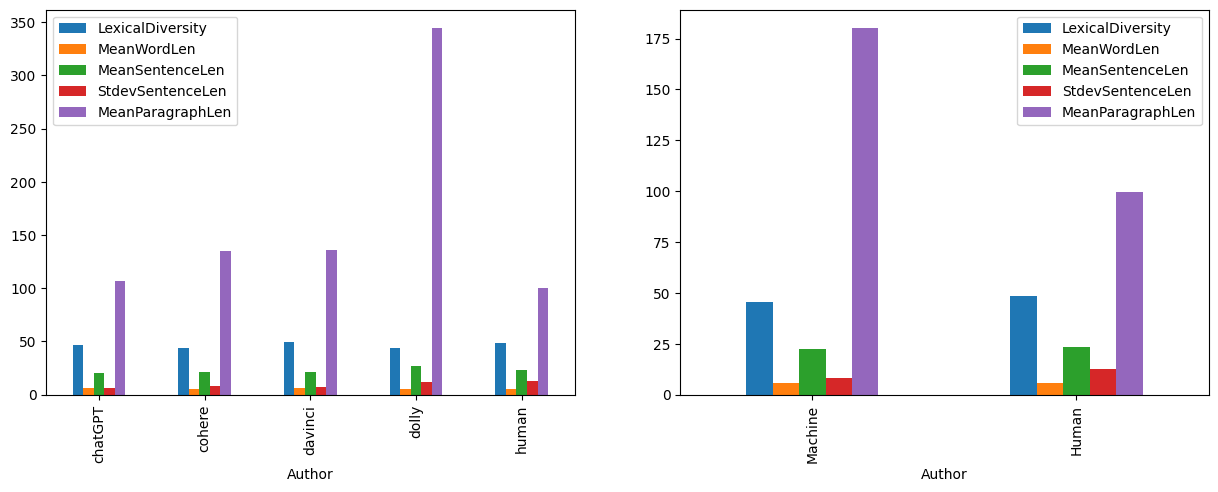

In [ ]:
plot_group(phraseology)

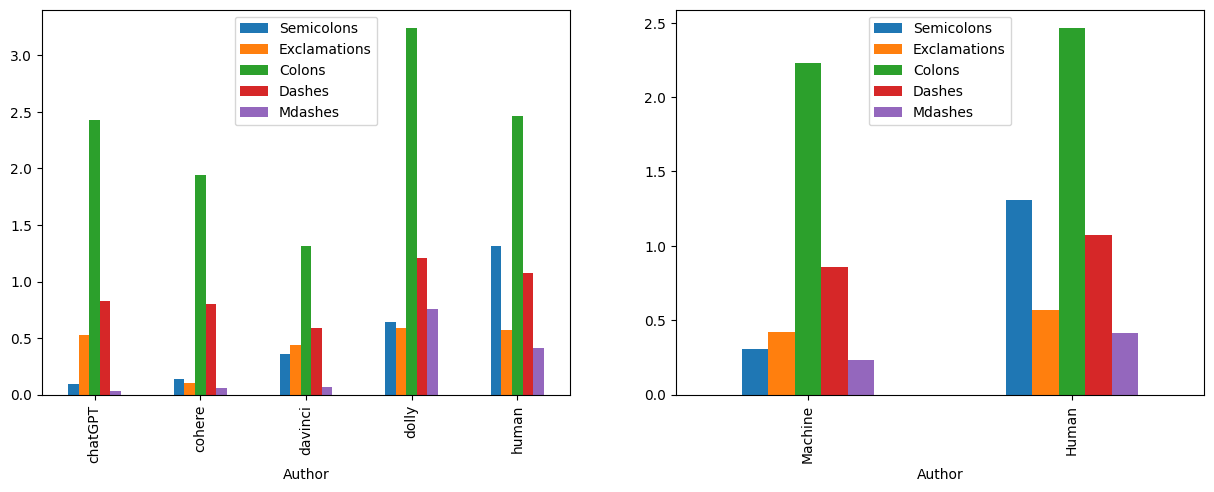

In [ ]:
plot_group(punctuation)

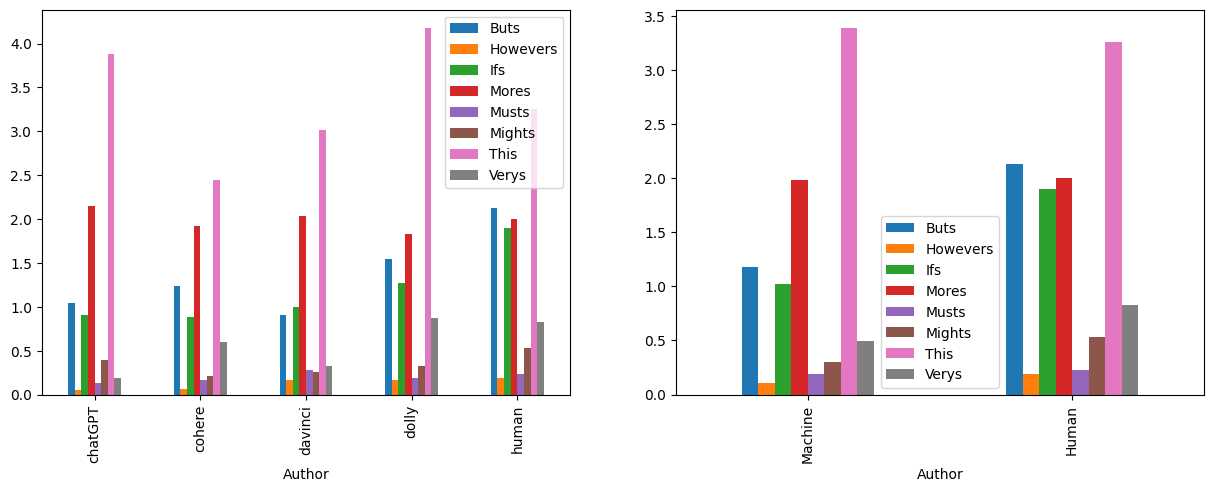

In [ ]:
plot_group(lexical_usage_1)

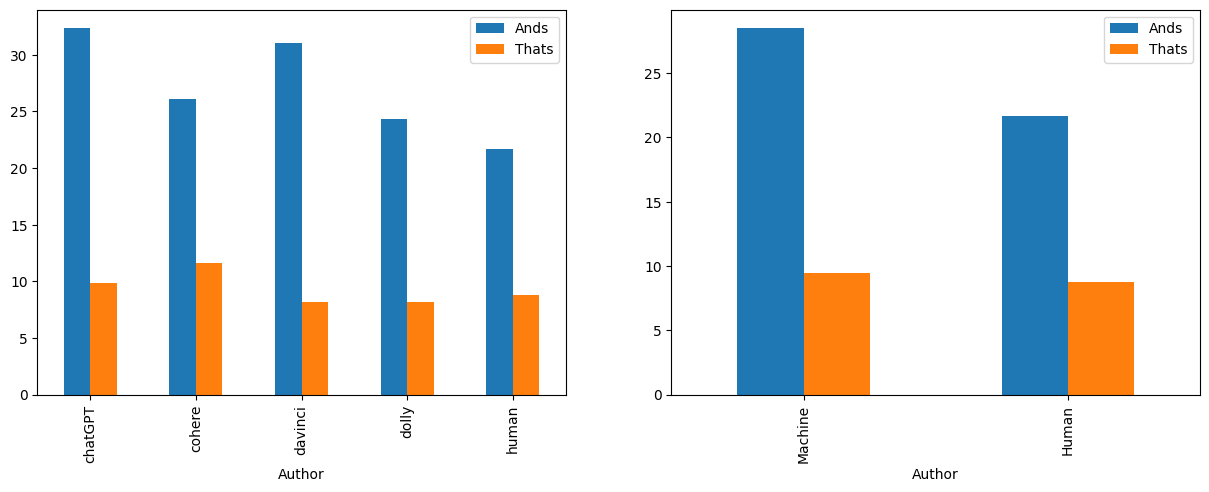

In [ ]:
plot_group(lexical_usage_2)

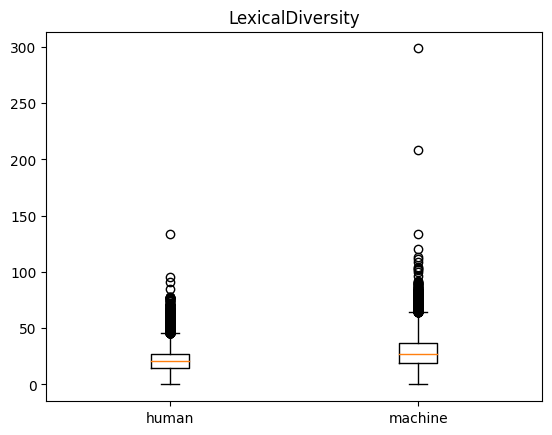

In [ ]:
df1 = df_stylometry[df_stylometry["Author"] == "human"]["Ands"]
df2 = df_stylometry[df_stylometry["Author"] != "human"]["Ands"]
plt.boxplot([df1,df2], labels=["human", "machine"])
plt.title("LexicalDiversity")
plt.show()

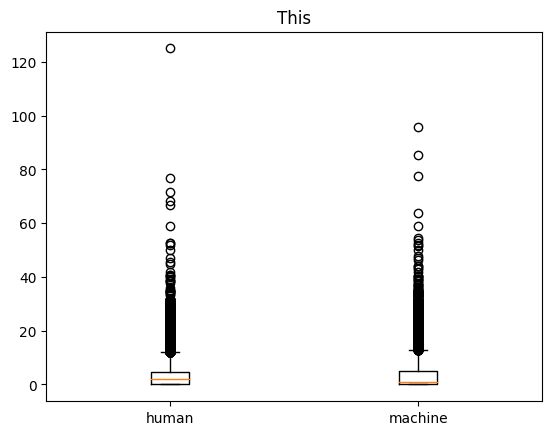

In [ ]:
df1 = df_stylometry[df_stylometry["Author"] == "human"]["This"]
df2 = df_stylometry[df_stylometry["Author"] != "human"]["This"]
plt.boxplot([df1,df2], labels=["human", "machine"])
plt.title("This")
plt.show()

#### Grafica de Datos

In [ ]:
vectors = df_stylometry.drop(labels=["Author", "Title", "Quotes"], axis=1, inplace=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# Caso para estandarizar datos
ns_vectors = StandardScaler().fit_transform(vectors)
ns_vectors = MinMaxScaler().fit_transform(ns_vectors)

In [ ]:
# Cambiar 'vectors' para graficar otros conjuntos
output = PCA(n_components=2).fit_transform(vectors)
output_machine = output[df_stylometry["Author"] != "human"]
output_human = output[df_stylometry["Author"] == "human"]

Text(0.5, 1.0, 'Phraseology (DocumentLen)')

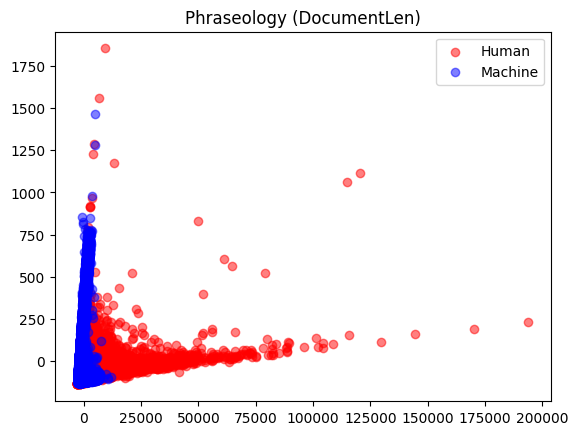

In [ ]:
plt.scatter(*output_human.T, c='r', alpha=0.5, label='Human')
plt.scatter(*output_machine.T, c='b', alpha=0.5, label='Machine')
plt.legend()
plt.title("Phraseology (DocumentLen)")

### Estilometria con POS (Parts-Of-Speech) Tagging

##### Generación del csv con bigramas de POS

In [ ]:
!python -m nltk.downloader maxent_treebank_pos_tagger averaged_perceptron_tagger tagsets

In [ ]:
with open("SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl") as f:
  df = pd.read_json(f, lines=True)

In [ ]:
# POS Tagging
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import bigrams
from collections import Counter

nltk.download('punkt')

def pos_bigrams(row):
  """ Genera un Counter con los bigramas de POS del texto de la columna dada """
  text = row["text"]
  verb = lambda t: t.startswith("V")
  adjective = lambda t: t.startswith("J")
  noun = lambda t: t.startswith("N")
  # Era preposition + verb pero en ingles no funciona
  pairs = [(verb, "IN"), (verb, adjective), (noun, adjective)]

  tags = nltk.pos_tag(word_tokenize(text))
  pos_bigrams = bigrams([t[1] for t in tags])
  return Counter(pos_bigrams)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
import pandas as pd

r = df.progress_apply(pos_bigrams, axis=1)

  0%|          | 0/119757 [00:00<?, ?it/s]

In [ ]:
import pickle
file_path = '/content/drive/MyDrive/SemEval/raw_pos_tag'

In [ ]:
with open(file_path, 'wb') as f:
  pickle.dump(r, f)

In [ ]:
with open(file_path, 'rb') as f:
  r = pickle.load(f)

In [ ]:
r

0         {('NNP', 'NNP'): 22, ('NNP', 'VBZ'): 4, ('VBZ'...
1         {('VBG', 'NNP'): 1, ('NNP', 'NNP'): 31, ('NNP'...
2         {('NNP', 'NNP'): 23, ('NNP', 'CD'): 18, ('CD',...
3         {('WRB', 'TO'): 2, ('TO', 'VB'): 21, ('VB', 'N...
4         {('WRB', 'TO'): 1, ('TO', 'VB'): 11, ('VB', 'N...
                                ...                        
119752    {('DT', 'NN'): 3, ('NN', 'VBZ'): 1, ('VBZ', 'D...
119753    {('PRP', 'VBD'): 2, ('VBD', 'DT'): 2, ('DT', '...
119754    {('DT', 'NNS'): 3, ('NNS', 'VBP'): 5, ('VBP', ...
119755    {('DT', 'NN'): 8, ('NN', 'VBZ'): 2, ('VBZ', 'D...
119756    {('DT', 'NN'): 11, ('NN', 'VBZ'): 4, ('VBZ', '...
Length: 119757, dtype: object

In [ ]:
tag_list = ["$", "''", "(", ")", ",", "--", ".", ":", "CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", "NN", "NNP", "NNPS", "NNS", "PDT", "POS", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "SYM", "TO", "UH", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB", "``"]
pairs = [(x,y) for x in tag_list for y in tag_list] # 2025 pares, 45 tags
null_counter = Counter({pair:0 for pair in pairs})

def counter_to_series(counter):
  tmp_counter = counter.copy()
  tmp_counter.update(null_counter)
  return pd.Series(tmp_counter)

In [ ]:
file_path = f'/content/drive/MyDrive/SemEval/all_pos_tag_df_{i}.csv'
all_pos_tag_df.to_csv(file_path)

In [ ]:
step = 10000

for i in range(1,13):
  file_path = f'/content/drive/MyDrive/SemEval/all_pos_tag_df_{i}.csv'
  all_pos_tag_df = r[(i-1)*step:i*step].progress_apply(counter_to_series)
  all_pos_tag_df.to_csv(file_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9757 [00:00<?, ?it/s]

In [ ]:
i = 1
file_path = f'/content/drive/MyDrive/SemEval/all_pos_tag_df_{i}.csv'
all_pos_tag_df = pd.read_csv(file_path, header=[0,1])

for i in range(2,13):
  file_path = f'/content/drive/MyDrive/SemEval/all_pos_tag_df_{i}.csv'
  tmp_df = pd.read_csv(file_path, header=[0,1])
  all_pos_tag_df = pd.concat([all_pos_tag_df, tmp_df], ignore_index=True, sort=False)

all_pos_tag_df = all_pos_tag_df.fillna(0).astype(int)

In [ ]:
all_pos_tag_df.drop(labels='Unnamed: 0_level_0', axis=1, inplace=True)

<ipython-input-13-2cb7ac5ef657>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  all_pos_tag_df.drop(labels='Unnamed: 0_level_0', axis=1, inplace=True)


In [ ]:
all_pos_tag_df.insert(0, 'Author', df['model'])

In [ ]:
all_pos_tag_df

NNP     VBZ  DT  JJ  NN     WDT VBZ NNS  ...   # MD  #                 \
       NNP VBZ  DT  JJ  NN  NN WDT VBZ NNS  IN  ... PDT  # WP VBZ  ( WDT JJS   
0       22   4   1   9   8   5   1   1   1   2  ...   0  0  0   0  0   0   0   
1       31   2   1  14  11  14   4   4   0  12  ...   0  0  0   0  0   0   0   
2       23   0   2   7  11  36   1   0   0   8  ...   0  0  0   0  0   0   0   
3        1   4   2  21  26  16   2   3   0  11  ...   0  0  0   0  0   0   0   
4        3   0   1  16  17   0   0   0   0   7  ...   0  0  0   0  0   0   0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  .. .. ..  .. ..  ..  ..   
119752   0   0   1   1   2   1   0   0   0   1  ...   0  0  0   0  0   0   0   
119753   8   2   4  20  27  10   0   1   0  13  ...   0  0  0   0  0   0   0   
119754   0   3   1  10  10   7   0   0   0   1  ...   0  0  0   0  0   0   0   
119755   4   0   2   4   5   5   0   1   0   4  ...   0  0  0   0  0   0   0   
119756   2   1   2   7   7   3   1   1   0   6  ...   0  0  0   0  0   0   0   

        $  # JJS  
        #  $   #  
0       0  0   0  
1       0  0   0  
2       0  0   0  
3       0  0   0  
4       0  0   0  
...    .. ..  ..  
119752  0  0   0  
119753  0  0   0  
119754  0  0   0  
119755  0  0   0  
119756  0  0   0  

[119757 rows x 2095 columns]

In [ ]:
all_pos_tag_df.to_csv("/content/drive/MyDrive/SemEval/all_pos_tag_df.csv", index=False)

##### Generación de gráficas con bigramas de POS

In [ ]:
import pandas as pd

In [ ]:
all_pos_tag_df = pd.read_csv("/content/drive/MyDrive/SemEval/all_pos_tag_df.csv", header=[0,1])
all_pos_tag_df

NNP     VBZ  DT  JJ  NN     WDT VBZ NNS  ...   # MD  #                 \
       NNP VBZ  DT  JJ  NN  NN WDT VBZ NNS  IN  ... PDT  # WP VBZ  ( WDT JJS   
0       22   4   1   9   8   5   1   1   1   2  ...   0  0  0   0  0   0   0   
1       31   2   1  14  11  14   4   4   0  12  ...   0  0  0   0  0   0   0   
2       23   0   2   7  11  36   1   0   0   8  ...   0  0  0   0  0   0   0   
3        1   4   2  21  26  16   2   3   0  11  ...   0  0  0   0  0   0   0   
4        3   0   1  16  17   0   0   0   0   7  ...   0  0  0   0  0   0   0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  .. .. ..  .. ..  ..  ..   
119752   0   0   1   1   2   1   0   0   0   1  ...   0  0  0   0  0   0   0   
119753   8   2   4  20  27  10   0   1   0  13  ...   0  0  0   0  0   0   0   
119754   0   3   1  10  10   7   0   0   0   1  ...   0  0  0   0  0   0   0   
119755   4   0   2   4   5   5   0   1   0   4  ...   0  0  0   0  0   0   0   
119756   2   1   2   7   7   3   1   1   0   6  ...   0  0  0   0  0   0   0   

        $  # JJS  
        #  $   #  
0       0  0   0  
1       0  0   0  
2       0  0   0  
3       0  0   0  
4       0  0   0  
...    .. ..  ..  
119752  0  0   0  
119753  0  0   0  
119754  0  0   0  
119755  0  0   0  
119756  0  0   0  

[119757 rows x 2095 columns]

In [ ]:
# Lo utiliza para las etiquetas únicamente
df_stylometry = pd.read_csv("/content/drive/MyDrive/SemEval/stylometry_train.csv")

In [ ]:
output = PCA(n_components=2).fit_transform(all_pos_tag_df)
output_machine = output[df_stylometry["Author"] != "human"]
output_human = output[df_stylometry["Author"] == "human"]

Text(0.5, 1.0, 'POS bigrams PCA')

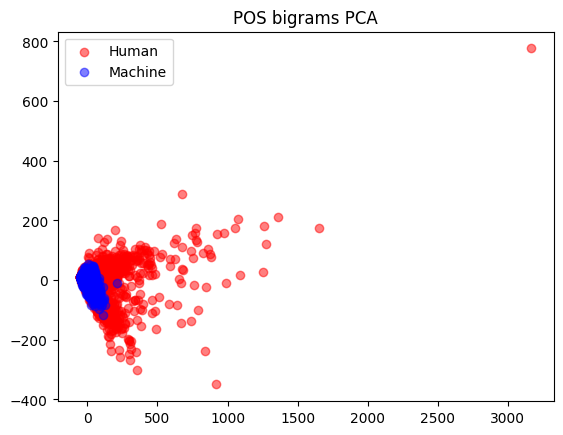

In [ ]:
plt.scatter(*output_human.T, c='r', alpha=0.5, label='Human')
plt.scatter(*output_machine.T, c='b', alpha=0.5, label='Machine')
plt.legend()
plt.title("POS bigrams PCA")

##### Generación de csv con unigramas de POS

In [ ]:
def unigrams_pos(row):
  """ Devuelve una Serie de pandas con el conteo de los Tags de POS en el
  texto de la columna dada """
  text = row["text"]
  tags = nltk.pos_tag(word_tokenize(text))
  return pd.Series(Counter([t[1] for t in tags]))

In [ ]:
with open("SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl") as f:
  df = pd.read_json(f, lines=True)

In [ ]:
unigrams_df = df.progress_apply(unigrams_pos, axis=1)

  0%|          | 0/119757 [00:00<?, ?it/s]

In [ ]:
unigrams_df = unigrams_df.fillna(0).astype(int)
unigrams_df

,#,$,'',(,),",",.,:,CC,CD,...,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0,0,4,0,0,33,36,1,18,12,...,3,6,4,6,11,1,1,0,2,4
1,0,2,11,0,0,25,68,3,21,25,...,3,9,14,19,13,5,1,0,4,11
2,0,0,0,1,1,30,90,0,25,43,...,2,9,25,25,14,1,0,0,6,0
3,0,0,0,11,11,27,67,19,38,14,...,4,8,5,22,15,4,3,1,3,0
4,0,0,0,2,2,26,42,0,23,10,...,1,20,14,21,8,0,5,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119752,0,0,0,0,2,4,4,0,3,2,...,0,3,1,2,1,0,0,0,0,0
119753,3,1,2,19,19,60,38,24,27,56,...,15,14,15,14,19,3,0,0,3,2
119754,0,0,0,7,7,12,9,1,3,8,...,2,6,4,6,9,1,0,0,1,0
119755,0,0,0,0,0,10,10,1,6,7,...,6,2,5,3,8,2,0,0,0,0


In [ ]:
unigrams_df.to_csv("/content/drive/MyDrive/SemEval/unigrams_df.csv", index=False)

##### Análisis de los unigramas de POS

In [ ]:
unigrams_df = pd.read_csv("/content/drive/MyDrive/SemEval/unigrams_df.csv")

In [ ]:
unigrams_tfidf = TfidfTransformer().fit_transform(unigrams_df)

In [ ]:
unigrams_df.columns.values

array(['#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX',
       'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP',
       'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT',
       'WP', 'WP$', 'WRB', '``'], dtype=object)

In [ ]:
unigrams_tfidf_df = pd.DataFrame(unigrams_tfidf.toarray()).rename(columns={i:v for i,v in enumerate(unigrams_df.columns.values)})

In [ ]:
N = unigrams_df.sum(axis=1)
# N / n = 1000 / x
unigrams_per_1000 = (unigrams_df * 1000).apply(lambda x : x / N, axis=0)

array([[<Axes: title={'center': '#'}, xlabel='Author'>,
        <Axes: title={'center': '$'}, xlabel='Author'>,
        <Axes: title={'center': "''"}, xlabel='Author'>,
        <Axes: title={'center': '('}, xlabel='Author'>,
        <Axes: title={'center': ')'}, xlabel='Author'>],
       [<Axes: title={'center': ','}, xlabel='Author'>,
        <Axes: title={'center': '.'}, xlabel='Author'>,
        <Axes: title={'center': ':'}, xlabel='Author'>,
        <Axes: title={'center': 'CC'}, xlabel='Author'>,
        <Axes: title={'center': 'CD'}, xlabel='Author'>],
       [<Axes: title={'center': 'DT'}, xlabel='Author'>,
        <Axes: title={'center': 'EX'}, xlabel='Author'>,
        <Axes: title={'center': 'FW'}, xlabel='Author'>,
        <Axes: title={'center': 'IN'}, xlabel='Author'>,
        <Axes: title={'center': 'JJ'}, xlabel='Author'>],
       [<Axes: title={'center': 'JJR'}, xlabel='Author'>,
        <Axes: title={'center': 'JJS'}, xlabel='Author'>,
        <Axes: title={'center': '

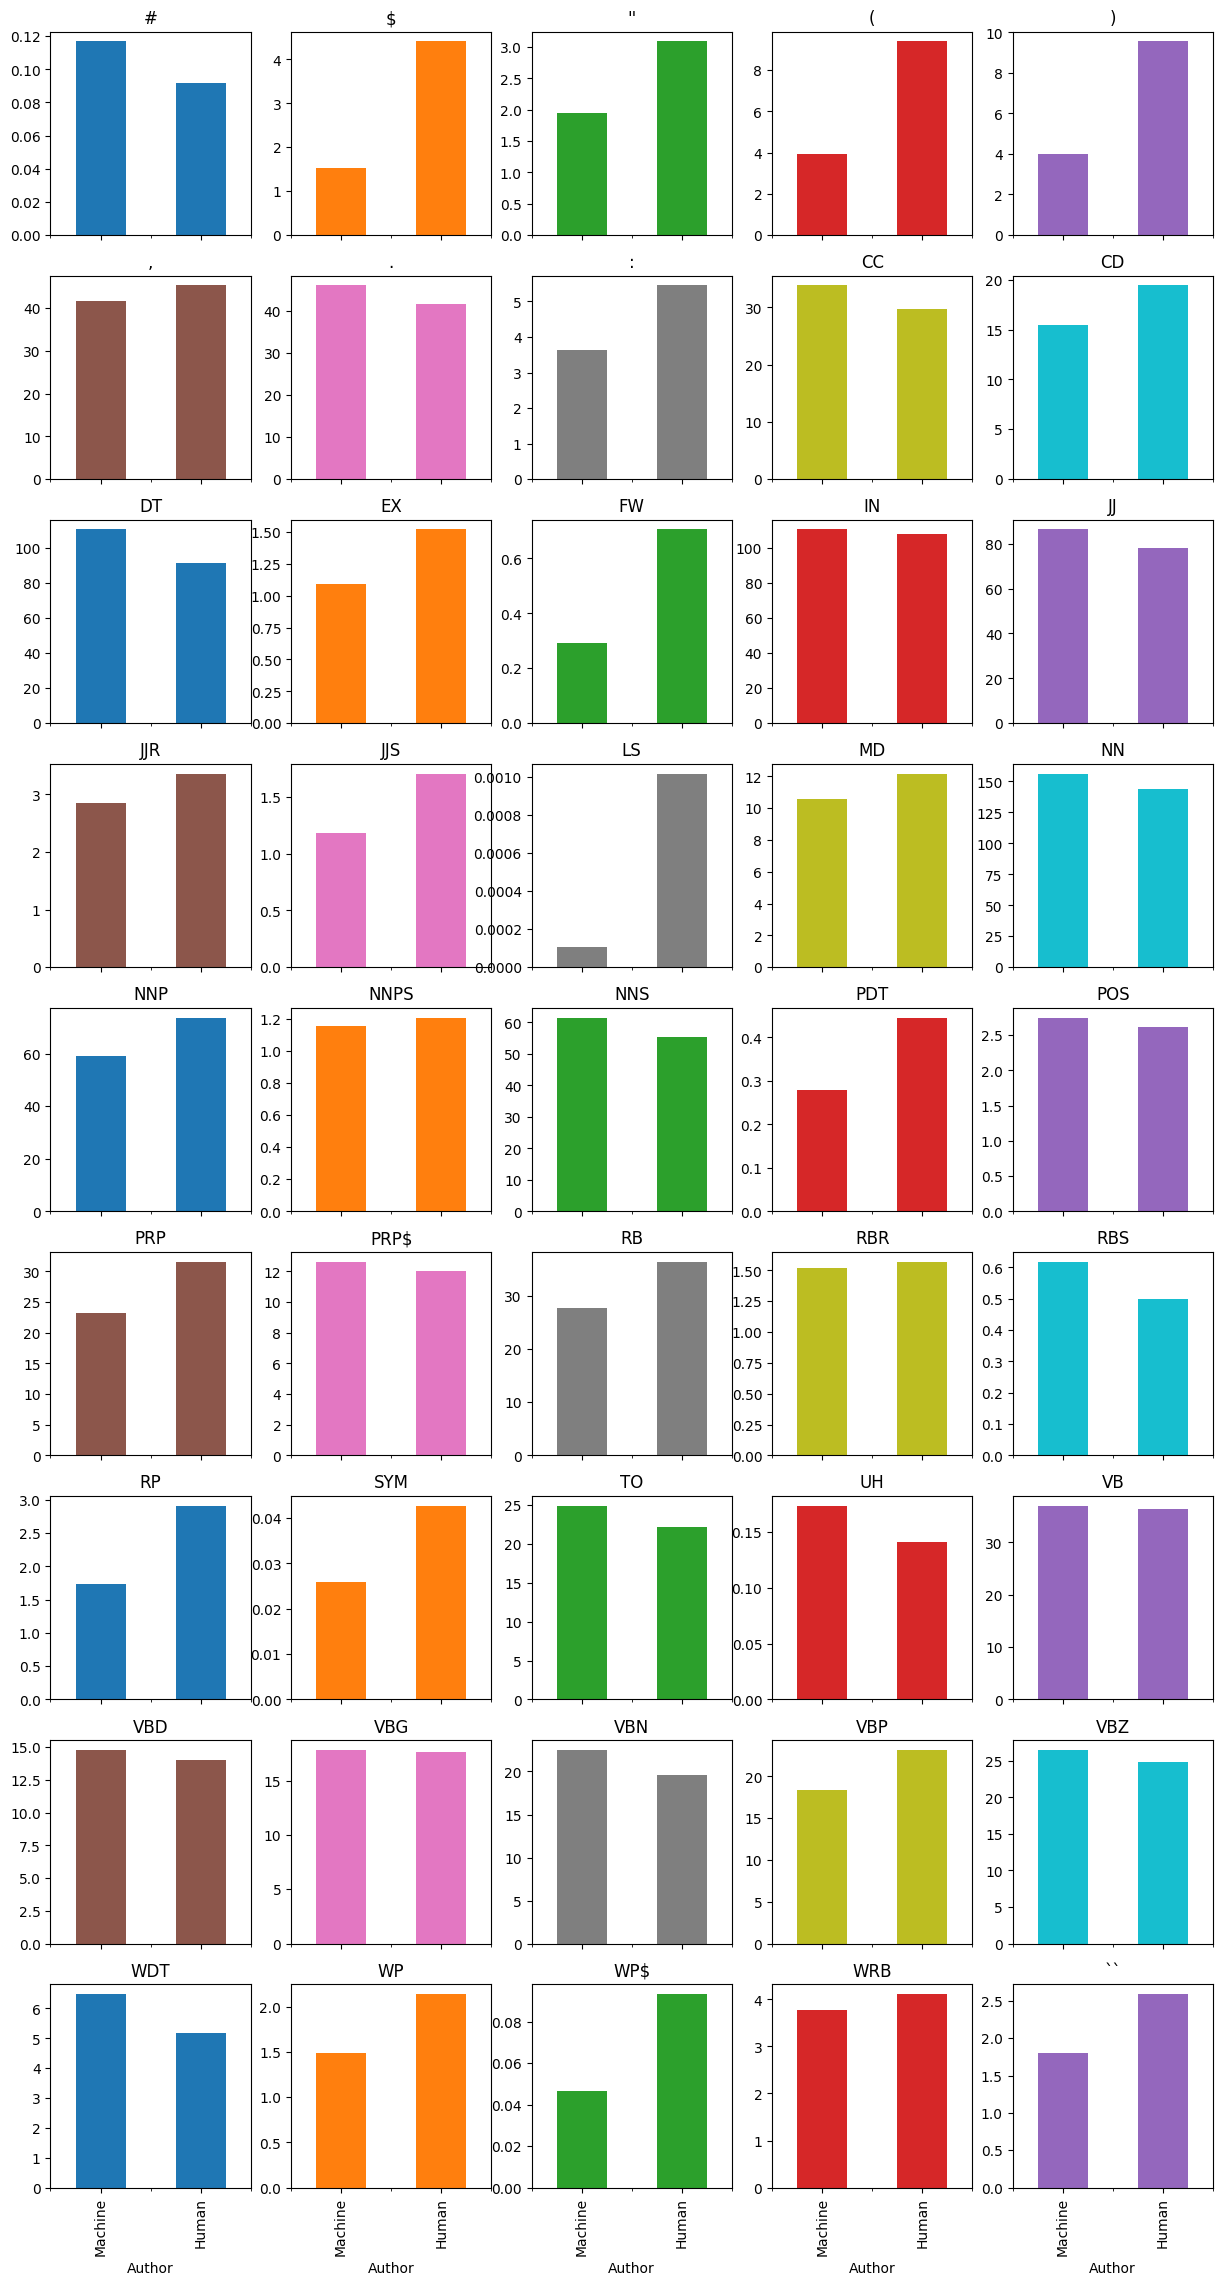

In [ ]:
unigrams_per_1000.groupby(df_stylometry['Author'] == 'human').mean().rename(index={True:"Human", False:"Machine"}).plot(kind='bar', subplots=True, figsize=(15,28), layout=(9,5), legend=False)

array([[<Axes: title={'center': '#'}, xlabel='Author'>,
        <Axes: title={'center': '$'}, xlabel='Author'>,
        <Axes: title={'center': "''"}, xlabel='Author'>,
        <Axes: title={'center': '('}, xlabel='Author'>,
        <Axes: title={'center': ')'}, xlabel='Author'>],
       [<Axes: title={'center': ','}, xlabel='Author'>,
        <Axes: title={'center': '.'}, xlabel='Author'>,
        <Axes: title={'center': ':'}, xlabel='Author'>,
        <Axes: title={'center': 'CC'}, xlabel='Author'>,
        <Axes: title={'center': 'CD'}, xlabel='Author'>],
       [<Axes: title={'center': 'DT'}, xlabel='Author'>,
        <Axes: title={'center': 'EX'}, xlabel='Author'>,
        <Axes: title={'center': 'FW'}, xlabel='Author'>,
        <Axes: title={'center': 'IN'}, xlabel='Author'>,
        <Axes: title={'center': 'JJ'}, xlabel='Author'>],
       [<Axes: title={'center': 'JJR'}, xlabel='Author'>,
        <Axes: title={'center': 'JJS'}, xlabel='Author'>,
        <Axes: title={'center': '

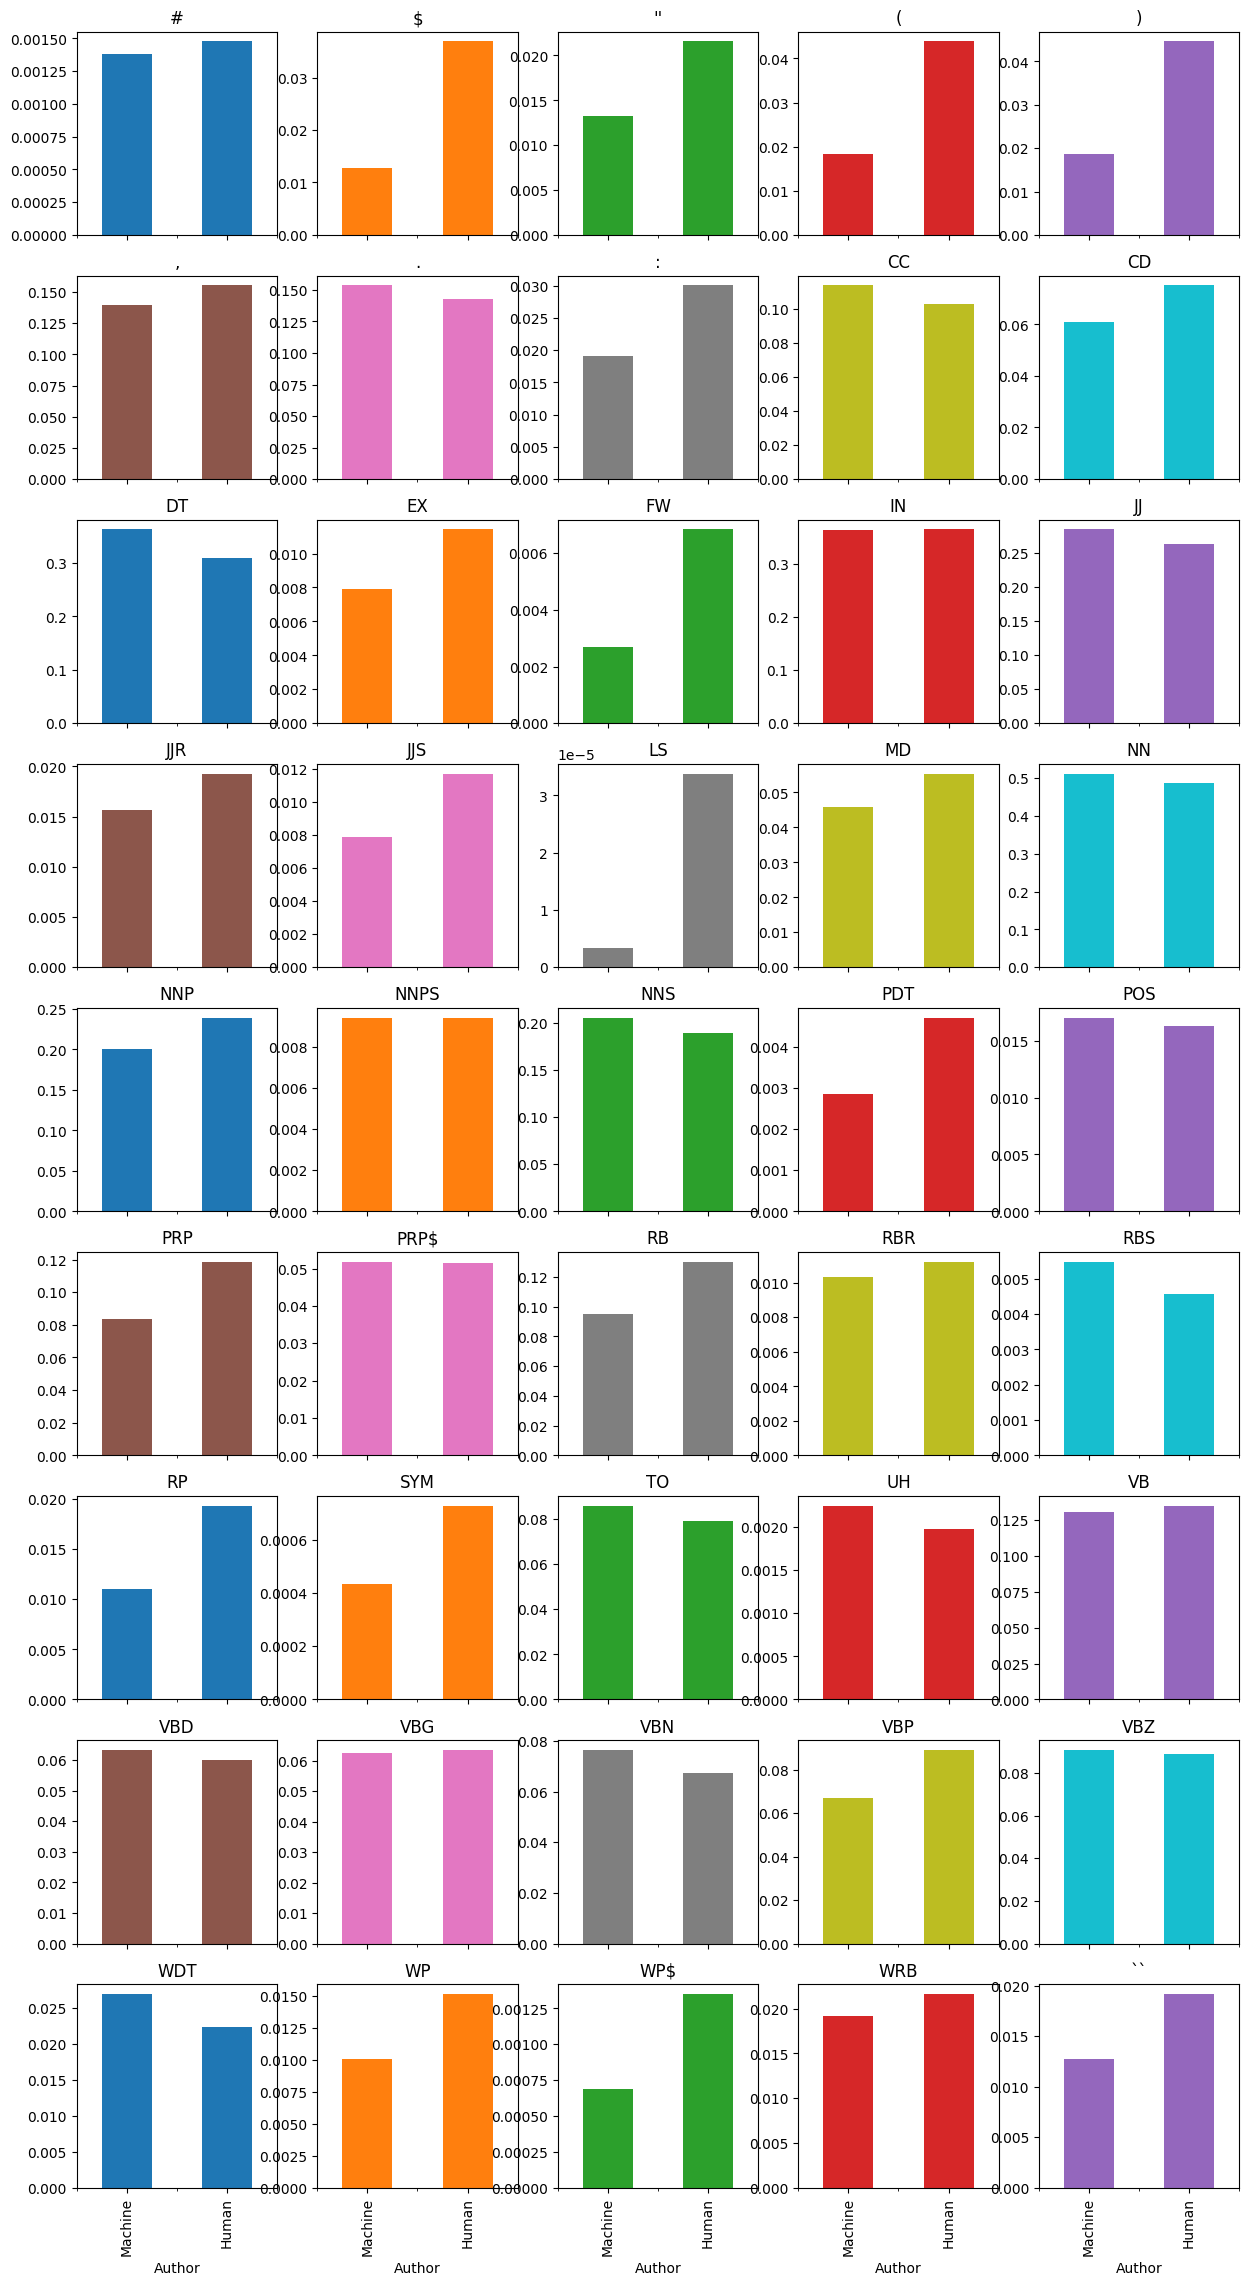

In [ ]:
unigrams_tfidf_df.groupby(df_stylometry['Author'] == 'human').mean().rename(index={True:"Human", False:"Machine"}).plot(kind='bar', subplots=True, figsize=(15,28), layout=(9,5), legend=False)

In [ ]:
import nltk
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Clasificación con estilometría

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
df_stylometry = pd.read_csv("/content/drive/MyDrive/SemEval/stylometry_train.csv")
X = df_stylometry.drop(columns=["Author", "Title"], axis=1)
y = (df_stylometry["Author"] != "human").to_numpy() * 1

In [ ]:
df_stylometry_dev = pd.read_csv("/content/drive/MyDrive/SemEval/stylometry_dev.csv")
X_dev = df_stylometry_dev.drop(columns=["Author", "Title"], axis=1)
y_dev = (df_stylometry_dev["Author"] != "human").to_numpy() * 1

In [ ]:
df_stylometry_test = pd.read_csv("/content/drive/MyDrive/SemEval/stylometry_test.csv")
X_test = df_stylometry_test.drop(columns=["Author", "Title"], axis=1)
y_test = (df_stylometry_test["Author"] != "human").to_numpy() * 1

In [ ]:
# Para el caso de estandarizar datos
X = StandardScaler().fit_transform(X)
X_dev = StandardScaler().fit_transform(X_dev)
X_test = StandardScaler().fit_transform(X_test)

X = MinMaxScaler().fit_transform(X)
X_dev = MinMaxScaler().fit_transform(X_dev)
X_test = MinMaxScaler().fit_transform(X_test)

In [ ]:
df_stylometry.columns

Index(['Author', 'Title', 'LexicalDiversity', 'MeanWordLen', 'MeanSentenceLen',
       'StdevSentenceLen', 'MeanParagraphLen', 'DocumentLen', 'Commas',
       'Semicolons', 'Quotes', 'Exclamations', 'Colons', 'Dashes', 'Mdashes',
       'Ands', 'Buts', 'Howevers', 'Ifs', 'Thats', 'Mores', 'Musts', 'Mights',
       'This', 'Verys'],
      dtype='object')

In [ ]:
phraseology   = ['LexicalDiversity', 'MeanWordLen', 'MeanSentenceLen', 'StdevSentenceLen', 'MeanParagraphLen', 'DocumentLen']
punctuation   = ['Commas', 'Semicolons', 'Quotes', 'Exclamations', 'Colons', 'Dashes', 'Mdashes']
lexical_usage = ['Ands', 'Buts', 'Howevers', 'Ifs', 'Thats', 'Mores', 'Musts', 'Mights', 'This', 'Verys']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

def acc(model, x_dev, x_test):
  calc_acc = lambda x,y: np.sum(model.predict(x) == y) / len(y)
  print("dev acc", calc_acc(x_dev, y_dev))
  print("test acc", calc_acc(x_test, y_test))

def test_models(x, x_dev, x_test):
  """ Utiliza varios modelos comunes para generar predicciones de evaluarlas

  Parámetros:
  x: Dataset
    Conjunto de datos de entramiento
  x_dev: Dataset
    Conjunto de datos de evaluación (dev)
  x_test: Dataset
    Conjunto de datos de prueba
  """
  # Random Forest
  print("Random Forest")
  random_forest = RandomForestClassifier()
  random_forest.fit(x,y)
  acc(random_forest, x_dev, x_test)
  print()

  # Stochastic Gradient Descent
  print("Stochastic Gradient Descent")
  sgd = SGDClassifier()
  sgd.fit(x,y)
  acc(sgd, x_dev, x_test)
  print()

  # Logistic Regression
  print("Logistic Regression")
  log_reg = LogisticRegression()
  log_reg.fit(x,y)
  acc(log_reg, x_dev, x_test)
  print()

  # Multinomial Naive Bayes
  print("Multinomial Naive Bayes")
  nb = MultinomialNB()
  nb.fit(x,y)
  acc(nb, x_dev, x_test)
  print()

# SVC quedó en una función aparte porque era bastante tardado
def test_svc(x, x_dev, x_train):
  print("SVC")
  svc = svm.SVC()
  svc.fit(x,y)
  acc(svc, x_dev, x_train)

In [ ]:
print("== Phraseology ==")
test_models(X[phraseology], X_dev[phraseology], X_test[phraseology])
print("== Punctuation ==")
test_models(X[punctuation], X_dev[punctuation], X_test[punctuation])
print("== Lexical Usage ==")
test_models(X[lexical_usage], X_dev[lexical_usage], X_test[lexical_usage])

== Phraseology ==
Random Forest
dev acc 0.6278
test acc 0.5683648459383753

dev acc 0.3942
test acc 0.5179154995331466

dev acc 0.4154
test acc 0.5592320261437909

dev acc 0.792
test acc 0.21271008403361344

== Punctuation ==
Random Forest
dev acc 0.5304
test acc 0.5118464052287581

dev acc 0.432
test acc 0.5138305322128851

dev acc 0.529
test acc 0.4691001400560224

dev acc 0.421
test acc 0.5612161531279178

== Lexical Usage ==
Random Forest
dev acc 0.5068
test acc 0.693218954248366

dev acc 0.4182
test acc 0.6584091970121382

dev acc 0.4014
test acc 0.6936858076563959

dev acc 0.4274
test acc 0.7219012605042017



In [ ]:
print("== Phraseology ==")
test_svc(X[phraseology], X_dev[phraseology], X_test[phraseology])
print("== Punctuation ==")
test_svc(X[punctuation], X_dev[punctuation], X_test[punctuation])
print("== Lexical Usage ==")
test_svc(X[lexical_usage], X_dev[lexical_usage], X_test[lexical_usage])

== Phraseology ==
dev acc 0.7448
test acc 0.23465219421101774
== Punctuation ==
dev acc 0.5102
test acc 0.482609710550887
== Lexical Usage ==
dev acc 0.4168
test acc 0.6653536414565826


In [ ]:
# Logistic Regression
print("Logistic Regression")
log_reg = LogisticRegression()
log_reg.fit(X,y)
acc(log_reg, X_dev, X_test)

Logistic Regression
dev acc 0.4176
test acc 0.4316059757236228


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
